# New York State Assembled Workers 

## Data Sources
https://www.kaggle.com/new-york-state/nys-assembled-workers'-compensation-claims
https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu

OIICS Codes (appears version 1.01 used): <br>
https://wwwn.cdc.gov/wisards/oiics/Trees/MultiTree.aspx?Year=2007

Understanding the claims process: <br>
http://www.wcb.ny.gov/content/main/onthejob/HowSystemWorks.jsp

New York State Regions: <br>
https://en.wikipedia.org/wiki/Category:Regions_of_New_York_(state)

New York State Zip Code GeoJSON: <br>
https://github.com/OpenDataDE/State-zip-code-GeoJSON


## Summary
This is a project predicting whether or not claims submitted to the Workers' Compensation Board (WCB) in New York State are controverted by insurance companies.  Some important features of the data set are the type of injury, the part of the body injured, the cause of the injury, and the wages of the employee.  A feature 'is_controverted' was added to the dataset set on whether or not there is a date in the dataset of when the WCB recieved a form from the insurance company controverting the claim.  This could be used to predict which claims would be more likely to need a higher burden of proof or legal represenatation.  As such, recall (the number of controverted claims identified out of all the controverted claims) is considered the important metric of this binary classification problem.  Four different models were considered: random forest, gradient boost, logistic regression, and light gradient boost (LightGBM). Light Gradient Boost had the best Reciever Operating Characteristics (ROC) curve and was selected as the best model to optimize.    <br>

Only 5% of the claims are controverted.  This makes it an unbalanced dataset.  Undersampling the majority class and SMOTE were both tried.  Undersampling the majority class gave a better model based on the ROC curve and is less computationally expensive because it uses fewer data points.  For these reasons, the undersampled data set was used for the final model. <br>

After optimization, the best LightGBM model had the following scores: <br>
Accuracy Score LightGBM: 0.758 <br>
Recall Score: 0.738 <br>
Precision Score: 0.156 <br>
Log-Loss: 0.512 <br>


## Info about data from Kaggle:
Content<br>
The Workers’ Compensation Board (WCB) administers and regulates workers’ compensation benefits, disability benefits, volunteer firefighters’ benefits, volunteer ambulance workers’ benefits, and volunteer civil defense workers’ benefits. The WCB processes and adjudicates claims for benefits; ensures employer compliance with the requirement to maintain appropriate insurance coverage; and regulates the various system stakeholders, including self-insured employers, medical providers, third party administrators, insurance carriers and legal representatives. Claim assembly occurs when the WCB learns of a workplace injury and assigns the claim a WCB claim number. The WCB “assembles” a claim in which an injured worker has lost more than one week of work, has a serious injury that may result in a permanent disability, is disputed by the carrier or employer, or receives a claim form from the injured worker (Form C-3). A reopened claim is one that has been reactivated to resolve new issues following a finding that no further action was necessary<br>

Context<br>
This is a dataset hosted by the State of New York. The state has an open data platform found here and they update their information according the amount of data that is brought in. Explore New York State using Kaggle and all of the data sources available through the State of New York organization page!<br>

Update Frequency: This dataset is updated quarterly.

In [231]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgbm

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# Plot Matplotlib inline
% matplotlib inline

In [3]:
data_path = 'nys-assembled-workers\'-compensation-claims/assembled-workers-compensation-claims-beginning-2000.csv'

# These features are dates
parse_dates = ['Assembly Date', 'Accident Date', 'ANCR Date', 'Controverted Date', 'Section 32 Date', 
               'PPD Scheduled Loss Date', 'PPD Non-Scheduled Loss Date', 'PTD Date', 'First Appeal Date',
              'C-2 Date', 'C-3 Date', 'First Hearing Date']

# Read in CSV
df = pd.read_csv(data_path, parse_dates=parse_dates)   

# Change to booleans
df['Accident'] = np.where(df['Accident'] == 'Y', 1, 0)
df['Occupational Disease'] = np.where(df['Occupational Disease'] == 'Y', 1, 0)

# Change parameter into a boolean
df['Attorney/Representative'] = np.where(df['Attorney/Representative'] == 'Y', 1, 0)

# UK is an abbreviation used for unknown, change to nan
df.loc[df['WCIO Part Of Body Code'] == 'UK'] = np.nan
df.loc[df['WCIO Nature of Injury Code'] == 'UK'] = np.nan
df.loc[df['WCIO Cause of Injury Code'] == 'UK'] = np.nan

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Limit analysis to workers compensation claims
df = df[df['Claim Type'] == 'Workers Compensation']

# Drop claims where gender is unknown, ~ 6000 claims
df = df[df['Gender'] != 'U']
df['GenderNum'] = np.where(df['Gender'] == 'M', 1, 0)

# Remove outlier salaries, some may be errors
df = df[df['Average Weekly Wage'] < 20000]

# Create some features on insurance carrier
df['State Ins Fund'] = np.where(df['Carrier Name'] == 'STATE INSURANCE FUND', 1, 0) 

# Add features about the location of the county of injury
counties = pd.read_csv('counties.csv', usecols=['Counties', 'Region', 'Upstate'])
df = df.merge(counties, left_on='County of Injury', right_on='Counties', how='left')
df.drop('Counties', axis=1, inplace=True)

# Convert these date variables to year, month, day
df['Assembly Year'] = df['Assembly Date'].dt.year
df['Assembly Month'] = df['Assembly Date'].dt.month
df['Assembly Day'] = df['Assembly Date'].dt.dayofweek

df['Accident Year'] = df['Accident Date'].dt.year
df['Accident Month'] = df['Accident Date'].dt.month
df['Accident Day'] = df['Accident Date'].dt.dayofweek

# Removes 182000 data points, but newly assembled data may not have been in the system long 
# enough to be controverted
df = df[df['Current Claim Status'] != 'NEWLY ASSEMBLED']
        
# Variable tracking if insurance company protested claim
df['is_controverted'] = np.where(df['Controverted Date'].isnull() == 1, 0, 1)

In [5]:
df.head()

,Claim Identifier,Claim Type,District Name,Average Weekly Wage,Current Claim Status,Claim Injury Type,Age at Injury,Assembly Date,Accident Date,ANCR Date,...,State Ins Fund,Region,Upstate,Assembly Year,Assembly Month,Assembly Day,Accident Year,Accident Month,Accident Day,is_controverted
0,4037088.0,Workers Compensation,BUFFALO,610.00,HEARING UNSET,PPD NSL,37.0,2015-06-30,2015-05-14,2015-10-29,...,0,Western New York,1.0,2015,6,1,2015.0,5.0,3.0,0
1,4039191.0,Workers Compensation,ALBANY,215.88,NO FURTHER ACTION,PPD NSL,70.0,2015-07-10,2015-07-01,2015-11-12,...,1,Capital District,1.0,2015,7,4,2015.0,7.0,2.0,0
2,4044565.0,Workers Compensation,NYC,530.72,NO FURTHER ACTION,PPD NSL,30.0,2015-07-13,2015-02-22,2016-03-09,...,1,Hudson Valley,0.0,2015,7,0,2015.0,2.0,6.0,0
3,4054147.0,Workers Compensation,NYC,609.08,NO FURTHER ACTION,PPD NSL,63.0,2015-07-24,2015-04-10,2016-01-04,...,0,New York City,0.0,2015,7,4,2015.0,4.0,4.0,1
4,4054674.0,Workers Compensation,NYC,400.00,NO FURTHER ACTION,PPD NSL,41.0,2015-07-31,2015-05-06,2016-01-28,...,0,Long Island,0.0,2015,7,4,2015.0,5.0,2.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1189256 entries, 0 to 1371344
Data columns (total 62 columns):
Claim Identifier                      1189256 non-null float64
Claim Type                            1189256 non-null object
District Name                         1189256 non-null object
Average Weekly Wage                   1189256 non-null float64
Current Claim Status                  1189256 non-null object
Claim Injury Type                     1189256 non-null object
Age at Injury                         1189256 non-null float64
Assembly Date                         1189256 non-null datetime64[ns]
Accident Date                         1188718 non-null datetime64[ns]
ANCR Date                             604980 non-null datetime64[ns]
Controverted Date                     68174 non-null datetime64[ns]
Section 32 Date                       63568 non-null datetime64[ns]
PPD Scheduled Loss Date               123282 non-null datetime64[ns]
PPD Non-Scheduled Loss Date         

In [7]:
df['Current Claim Status'].unique()

array(['HEARING UNSET', 'NO FURTHER ACTION', 'HEARING SET',
       'RE-OPENED ADMINISTRATIVELY', 'ADMINISTRATIVELY CLOSED',
       'MOTION SET', 'ARGUMENT SET', 'REFEREE - RESERVED DECISION',
       'CASE CANCELLED', 'RETURNED TO EXAMINING', 'BOARD RESTORAL'],
      dtype=object)

In [8]:
# How many data points claim age at injury is over 90?
df[df['Age at Injury'] >= 90]['Age at Injury'].count()

164

In [9]:
# Check the z_test value for a specific column value
#https://www.statisticshowto.datasciencecentral.com/z-test/
def z_test(df, column, value):
    n = df.shape[0]
    n_val = df[df[column] == value].shape[0]
    proportion_val = df[df[column] == value]['is_controverted'].sum()/n_val
    print('Proportion Controverted Claims\n')
    print(str(value) + ' proportion:{:.2f}'.format(proportion_val))
    n_others = n - n_val
    proportion_others = df[df[column] != value]['is_controverted'].sum()/n_others
    print('Proportion others:{:.2f}'.format(proportion_others))
    proportion_pop = df['is_controverted'].sum()/n
    print('Population proportion:{:.2f}'.format(proportion_pop))
    
    z = (proportion_val - proportion_others) / np.sqrt(proportion_pop * (1-proportion_pop) *
                                                      (1/n_val + 1/n_others))
    return z

## Injury Codes Comparison

In [10]:
#pd.crosstab(df['WCIO Part Of Body Code'], df['is_controverted'])
def percConvert(ser):
  return ser/float(ser[-1])

There are two different categories in the dataset for part of body injured, type of injury, and source of injury.  The WCIO codes are the standard workers' compensation codes and the OIICS codes are from the CDC.  The following section looks at the WCIO codes and which percentage of them map to each OIICS code.  This is visualized using a heatmap. If every instance of a WCIO code is coded as a specific OIICS code, the color on the heatmap corresponds to the color 1.0, The purpose of this is to see if these are redundant codes or if they are tracking slightly different information.  This is done for the part of the body, nature of the injury, and source of the injury. From these heatmaps it can be seen that only a couple of parameters directly map 1:1 between the WCIO code adn the OIICS code.  For instance, a number of different WCIO codes for body part are mapped to 23* (spine) and 8 (mulitple body parts) on the OIICS. This means that the two parameters are not completely redundant.

#### WCIO vs OIICS Part of Body Codes

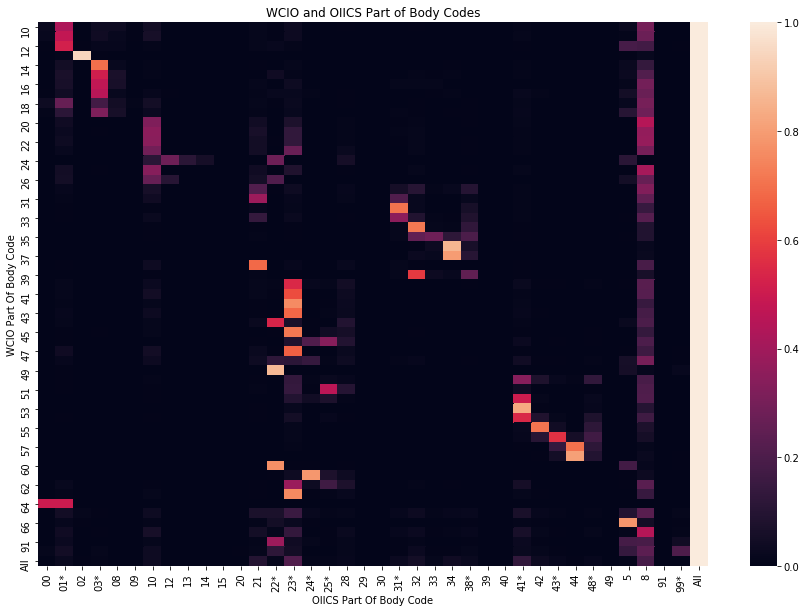

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(pd.crosstab(df['WCIO Part Of Body Code'],df['OIICS Part Of Body Code'], 
                        margins=True).apply(percConvert, axis=1))
plt.title('WCIO and OIICS Part of Body Codes')
plt.show()

The OIICS Part of Body Code 8 indicates multiple body parts. 23* is back includeing spine.  These two fields are nearly the same thing, but aren't always reported the exact same way. 

#### WCIO vs OIICS Nature of Injury Codes

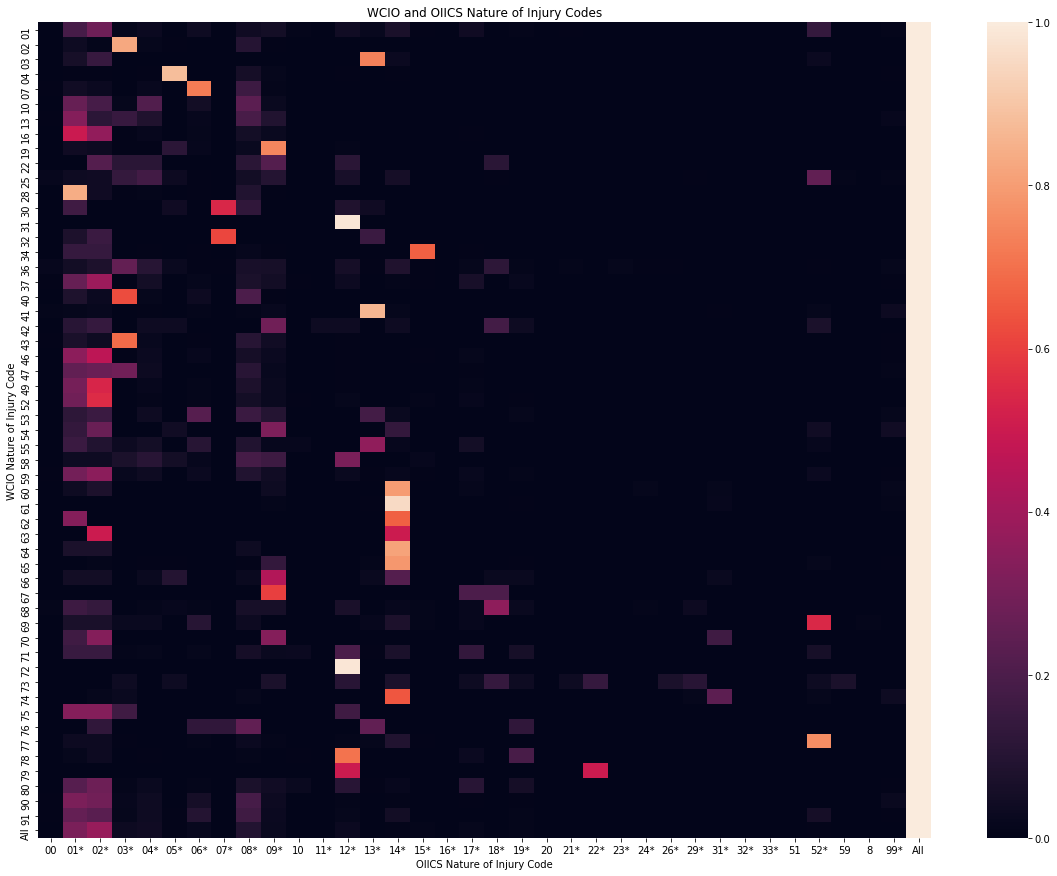

In [12]:
plt.figure(figsize=(20,15))
sns.heatmap(pd.crosstab(df['WCIO Nature of Injury Code'],df['OIICS Nature of Injury Code'], 
                        margins=True).apply(percConvert, axis=1))
plt.title('WCIO and OIICS Nature of Injury Codes')
plt.show()

The OIICS code 01* and 02* are:	01* : Traumatic injuries to bones, nerves, spinal cord,	02* : Traumatic injuries to muscles, tendons, ligaments, joints, etc.

#### WCIO And OIICS Cause of Injury Codes

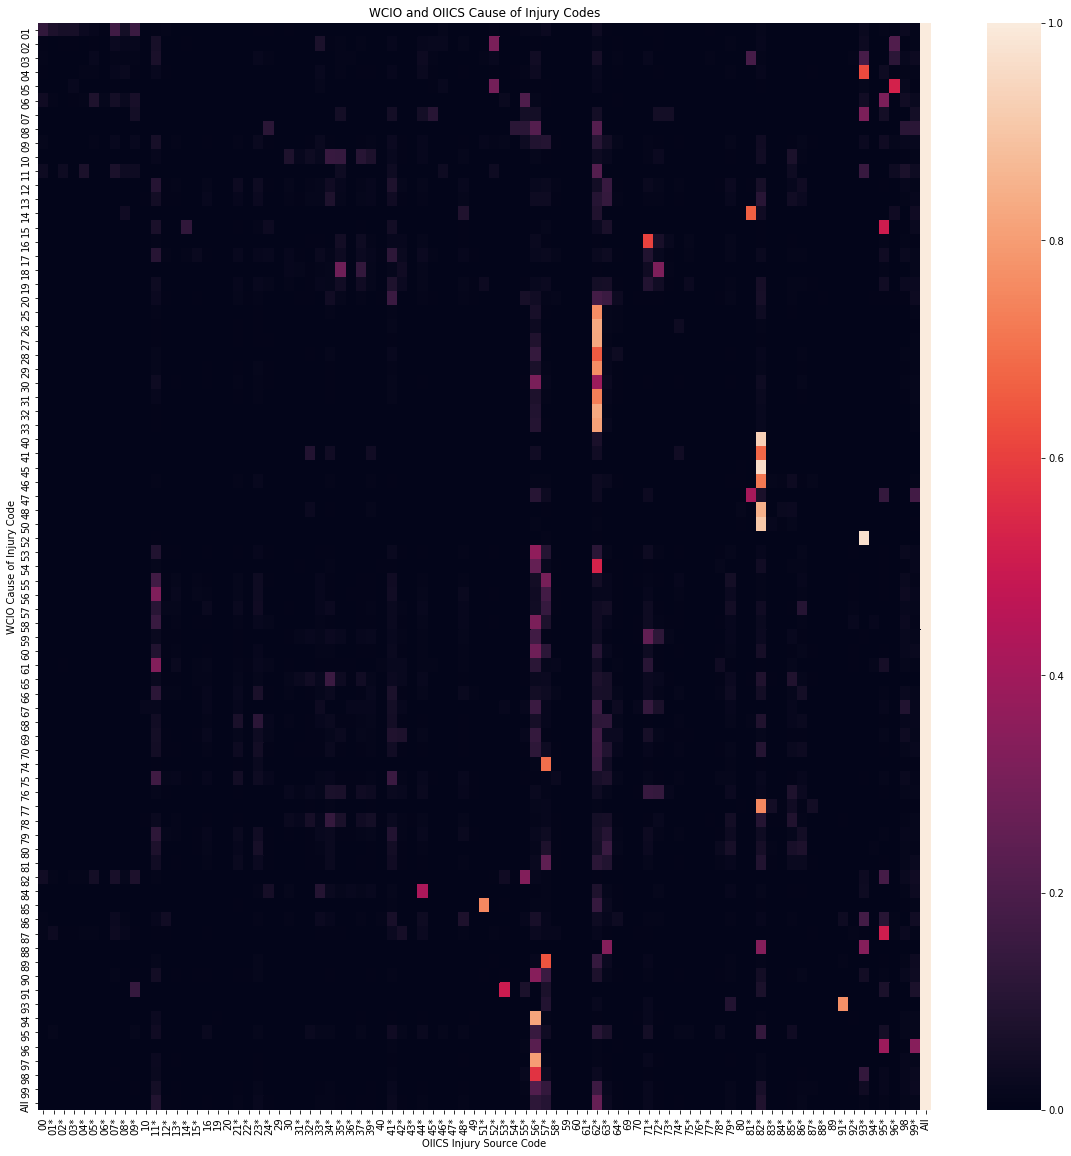

In [13]:
plt.figure(figsize=(20,20))
sns.heatmap(pd.crosstab(df['WCIO Cause of Injury Code'],df['OIICS Injury Source Code'],
                       margins=True).apply(percConvert, axis=1))

plt.title('WCIO and OIICS Cause of Injury Codes')
plt.show()

OIICS codes: 62* : Floors, walkways, ground surfaces, 56* : Person--injured or ill worker, 82* : Highway vehicle, motorized

### OIICS and WCIO codes are not the same
Take away from OIICS codes and WCIO codes, they are related, but there is also not a 1:1 correlation between most of them. However, more of the WCIO code fields are filled out than the OIICS fields.  As a result, for initial modeling the WCIO code fields will be used instead of the OIICS fields.  

### Relation Between WCIO Codes and Controverted
Next I wanted to look at whether there is any relation between codes and whether or not the claim is controverted by the insurance company.  First I looked at the WCIO Body Part codes.  Heart and Ear injuries have the highest rate of being controverted.  Fingers, eyes, and great toe injuries have some of the lowest rates of being controverted by the insurance company.  

The causes of injury with the highest rates of being controverted by the insurance companies are terrorism and continual noise.  

The nature of injury with the highest rates of being controverted is asbestosis from asbestos exposure.  This is probably much harder to prove than a puncture wound, which has a much lower rate of being controverted.   

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


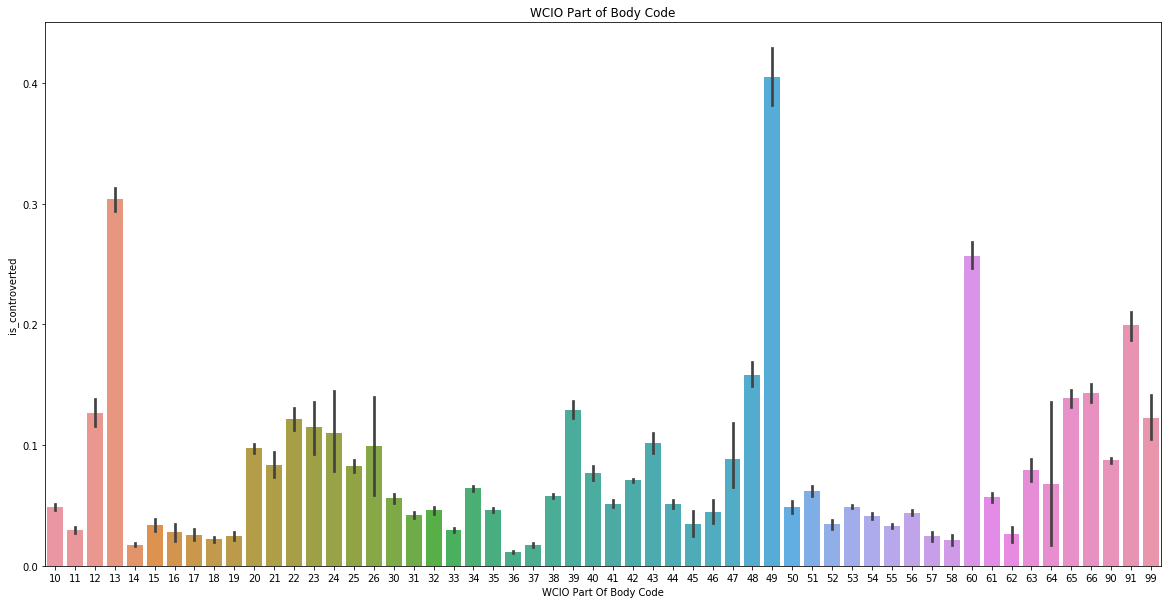

In [14]:
plt.figure(figsize=(20, 10))
sns.barplot(x='WCIO Part Of Body Code', y='is_controverted', data=df)
plt.title('WCIO Part of Body Code')
plt.show()

Code 13: Ears, Code 49: Heart, Code 60: Lungs, Code 91: BODY SYSTEMS AND MULTIPLE BODY SYSTEMS, Code 36: Fingers, Code 14: Eyes, Code 58: Great Toe

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


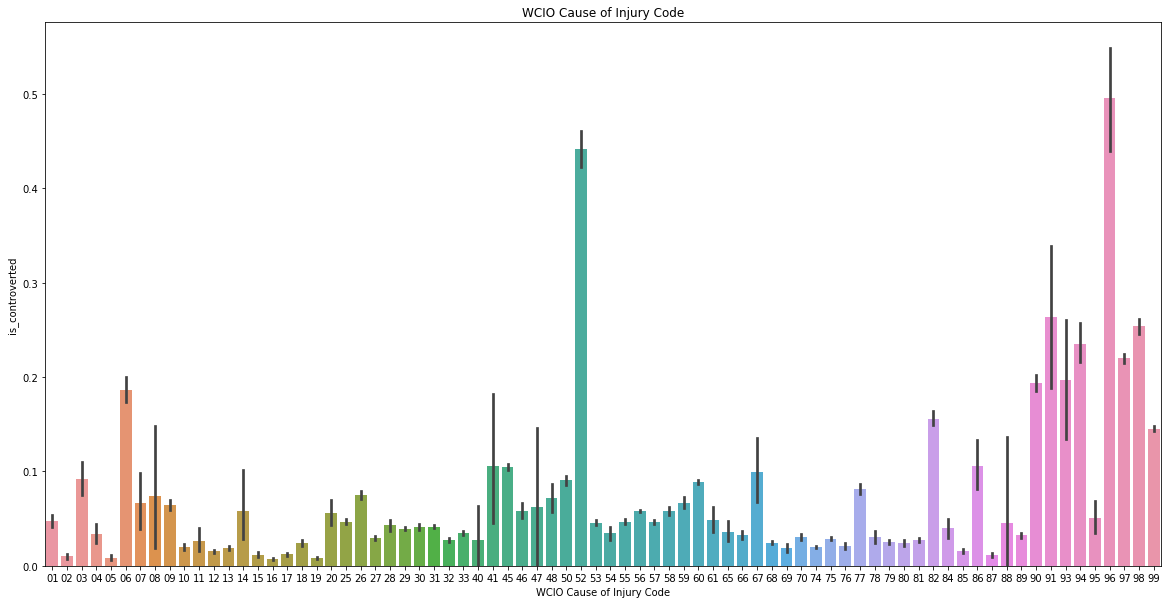

In [15]:
plt.figure(figsize=(20, 10))
sns.barplot(x='WCIO Cause of Injury Code', y='is_controverted', data=df)
plt.title('WCIO Cause of Injury Code')
plt.show()

52: Continual Noise, 96: Terrorism, 91: Mold, 94: Repetitive Motion, 98: Cumulative, no other code, 97: Repetitive motion (2 of these?), 2: Amputation, 5: 

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


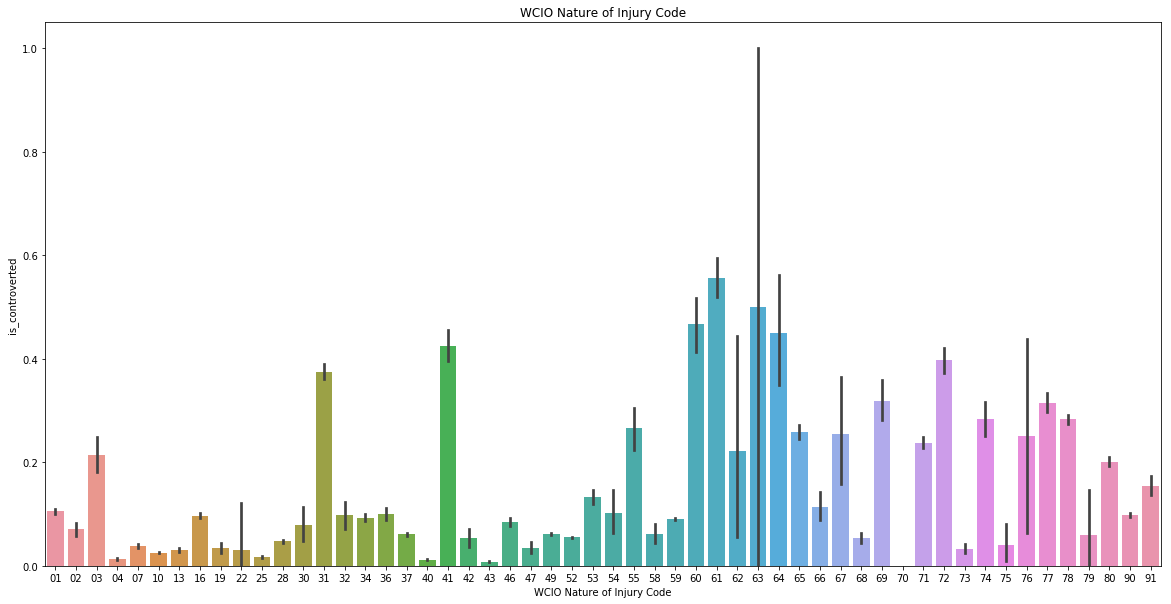

In [16]:
plt.figure(figsize=(20, 10))
sns.barplot(x='WCIO Nature of Injury Code', y='is_controverted', data=df)
plt.title('WCIO Nature of Injury Code')
plt.show()

61:  Asbestosis, 43: Puncture, 40: Laceration, 4: Burn,  

#### Commonly Injured Body Parts
Next I wanted to see which body parts are most commonly reported as injured in the claims.  This is in part to see if the most commonly injured are also the most controverted or the least.  Backs and knees are the most common reported injuries, but are not the most commonly (or least commonly) controverted.  This means that frequency is of type of injury is not the determing factor for whether or not a claim is controverted.

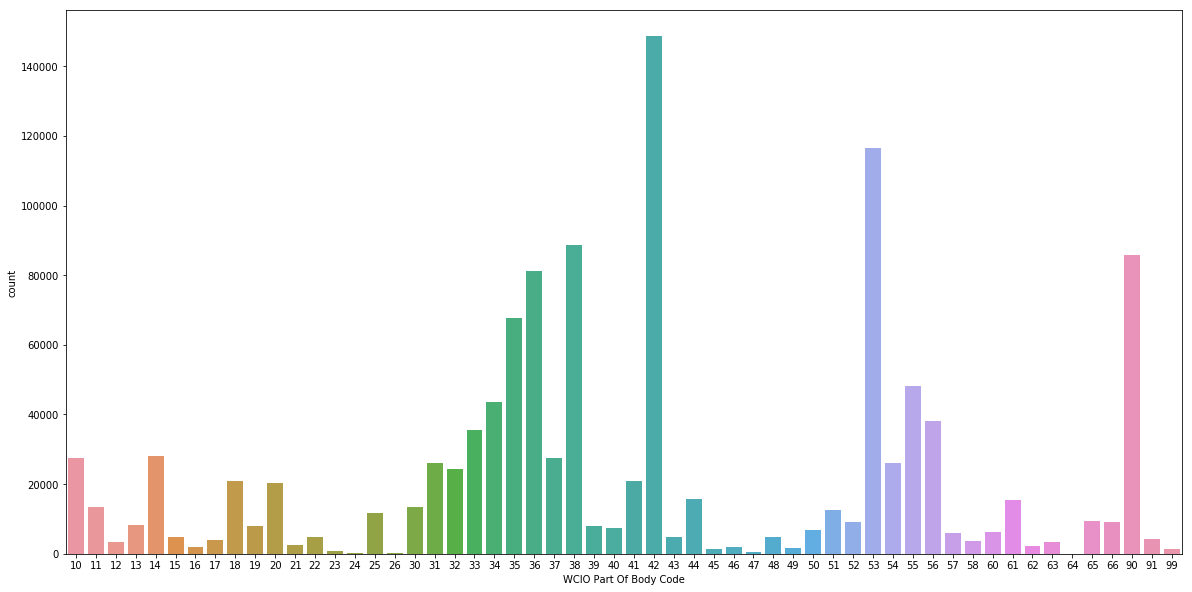

In [17]:
# Checking to see which injuries are the most common, are they also the most commonly protested?
plt.figure(figsize=(20, 10))
sns.countplot(x='WCIO Part Of Body Code', data=df)

42: Lower Back, 53: Knee, 90: Multiple parts - These are not the same ones that are most frequently protested by insurance companies

The following heatmap looks at whether a specific body part is most likely to always be injured the same way. If the WCIO Part of Body Code and WCIO Cause of Injury Code are perfectly related, then one would need to be dropped in the modeling.  On the following heatmap, the percent of a WCIO Body Code mapped to an individual WCIO Cause of Injury code is mapped.  Here it can be seen that there are different causes of injury for every body part.  This means that both could be considered when modeling.

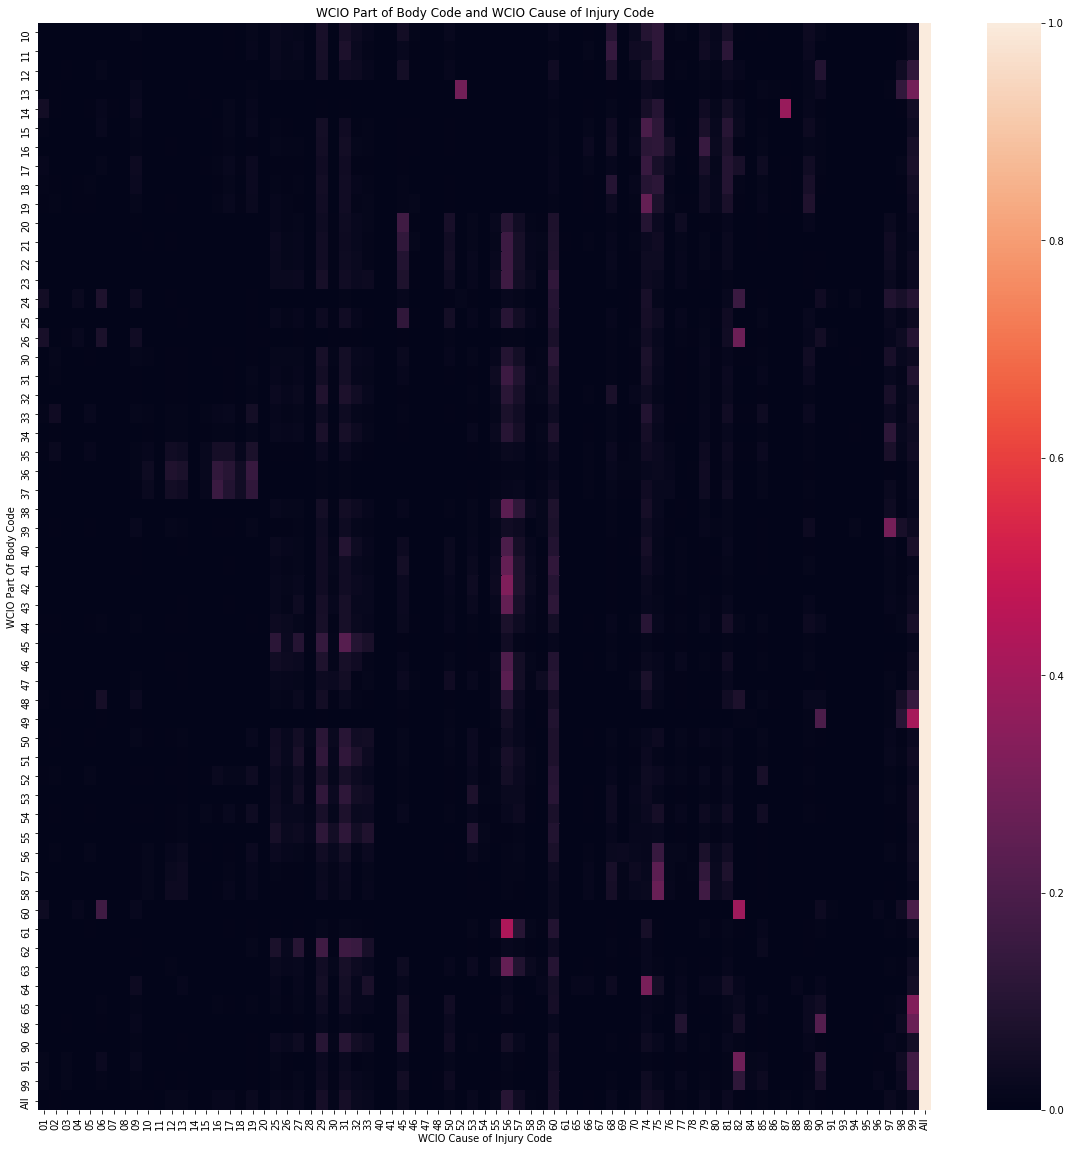

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(pd.crosstab(df['WCIO Part Of Body Code'],df['WCIO Cause of Injury Code'],
                       margins=True).apply(percConvert, axis=1))
plt.title('WCIO Part of Body Code and WCIO Cause of Injury Code')
plt.show()

The body part injured and cause of injury are related, but not 1:1. Should consider keeping both for modeling.

##  Demographics

### Gender, Wages, and Controverted

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


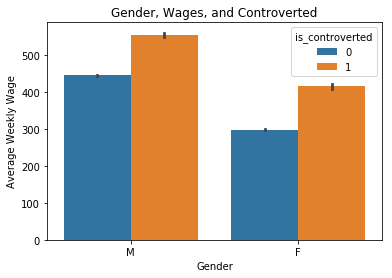

In [19]:
sns.barplot(x='Gender', y='Average Weekly Wage', hue='is_controverted', data=df)
plt.title('Gender, Wages, and Controverted')
plt.show()

This bar graph shows that the average weekly wage is higher for claims that are controverted for both males and females than on claims that are not controverted.  In addition, the average wage for males appears higher than that for females.  

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


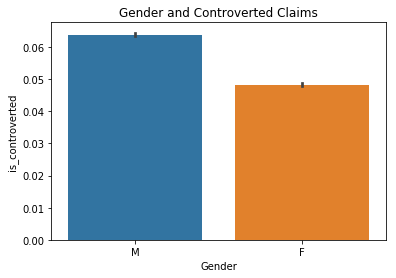

In [20]:
sns.barplot(x='Gender', y='is_controverted', data=df)
plt.title('Gender and Controverted Claims')
plt.show()

In [21]:
check_gender = z_test(df, 'Gender', 'M')
print('Z test value for Male claims controverted rate vs rest of population is: {:.2f}'.format(check_gender))

Proportion Controverted Claims

M proportion:0.06
Proportion others:0.05
Population proportion:0.06
Z test value for Male claims controverted rate vs rest of population is: 36.03


Interestingly, a higher proportion of cases from men are disputed than from women at a high Z-test value. This corresponds to a very low p-value and means this result is likely significant.

#### Age and Injury

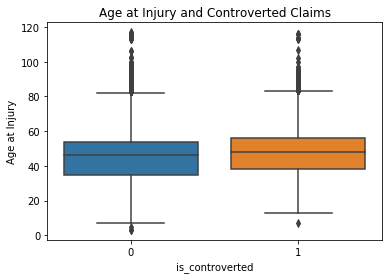

In [22]:
sns.boxplot(x='is_controverted', y='Age at Injury', data=df[df['Age at Injury'] > 1])
plt.title('Age at Injury and Controverted Claims')
plt.show()

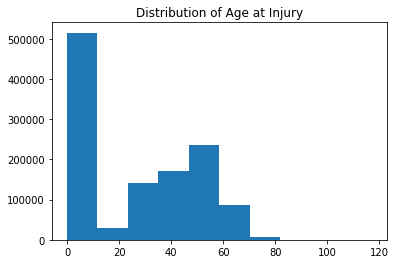

In [23]:
# Plot the distribution of ages
plt.hist(df['Age at Injury'])
plt.title('Distribution of Age at Injury')
plt.show()

From these two graphs we can see that more data points than not have the age at injury filled out as '0'.  Since this is not a realistic age for people at work, and the quantity of data points with this as a value, this category will not be used in the analysis.  The box plot above shows that for individuals with age at injury filled out, the mean age does not appear to be very different between claims that are controverted and claims that are not.  This is another justification for not using this feature for modeling.

Average Weekly Salary

Not Controverted: 381.739032
Controverted: 503.681793


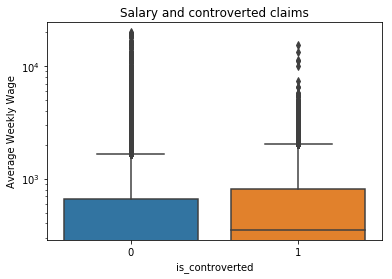

In [24]:
g = sns.boxplot(x='is_controverted', y='Average Weekly Wage', data=df)
g.set_yscale('log')
plt.title('Salary and controverted claims')

print('Average Weekly Salary\n')
print('Not Controverted: {:2f}'.format(df[df['is_controverted'] == 0]['Average Weekly Wage'].mean()))
print('Controverted: {:2f}'.format(df[df['is_controverted'] == 1]['Average Weekly Wage'].mean()))

The average weekly salary is higher for controverted claims, but there is a large weekly salary range for both categories.

### New York State Regions and Controverted Claims

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


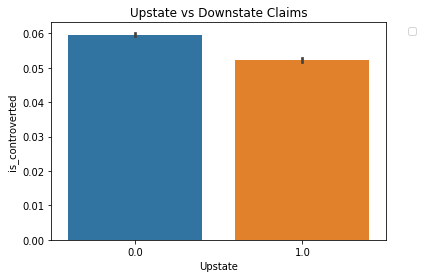

In [25]:
# Look at whether or not certain regions of New York have more claimes rejected
sns.barplot(x='Upstate', y='is_controverted', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Upstate vs Downstate Claims')
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


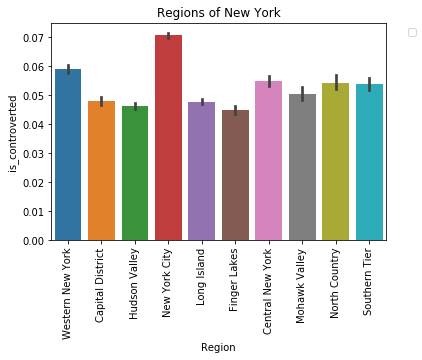

In [26]:
sns.barplot(x='Region', y='is_controverted', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation=90)
plt.title('Regions of New York')
plt.show()

In [27]:
print('The z value of NYC proportion of controverted claims vs the other regions is: {:.2f}'
      .format(z_test(df, 'Region', 'New York City')))



Proportion Controverted Claims

New York City proportion:0.07
Proportion others:0.05
Population proportion:0.06
The z value of NYC proportion of controverted claims vs the other regions is: 43.94


From these two plots we can see that there is an effect from the region of the state the claim occurred in. Upstate has a lower rate of controverted claims.  New York City (down state) has the hightest rate. From looking at z-tables, the corresponding p-value to a z-score of 36 is very small, which means that the difference in controverted rate between New York City and the other regions is significant.

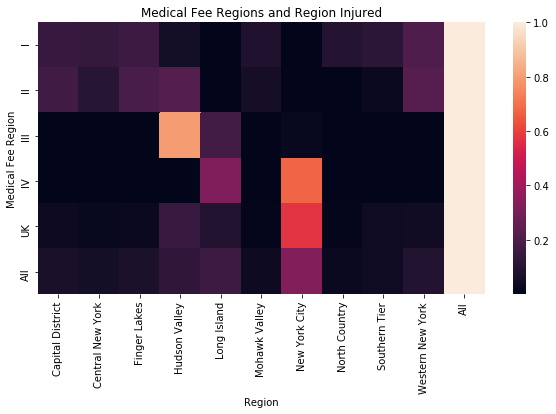

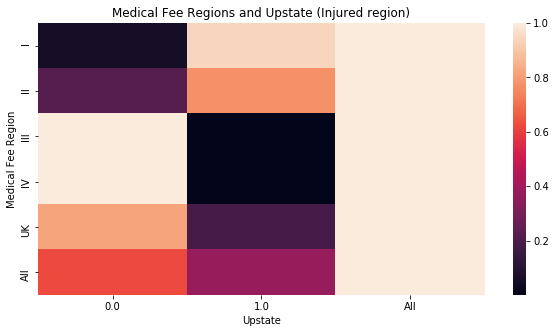

In [28]:
plt.figure(figsize=(10,5))
sns.heatmap(pd.crosstab(df['Medical Fee Region'],df['Region'], 
                        margins=True).apply(percConvert, axis=1))
plt.title('Medical Fee Regions and Region Injured')
plt.show()

plt.figure(figsize=(10,5))
sns.heatmap(pd.crosstab(df['Medical Fee Region'],df['Upstate'], 
                        margins=True).apply(percConvert, axis=1))
plt.title('Medical Fee Regions and Upstate (Injured region)')
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


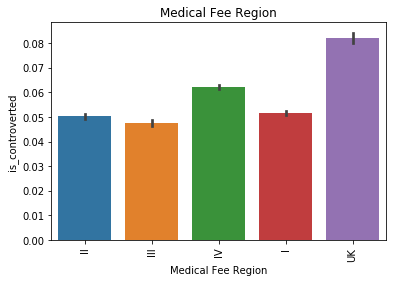

In [29]:
sns.barplot(x='Medical Fee Region', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.title('Medical Fee Region')
plt.show()

The Medical Fee Region and the location the injury occurred are related, but not perfectly. The medical fee region is where the medical treatment is expected to occur, and the injury region is where the injury occurred. Some people probably either moved or sought treatment elsewhere.  Due to the number of unknowns, will use region of injury.

In [30]:
# This table is used to plot the number of claims in each zipcode
# Zip Code is current home address
table1 = pd.DataFrame(df.groupby(by='Zip Code')['is_controverted'].count().reset_index())
table1.columns = ['ZipCode', 'CountClaims']
table1 = table1[table1['ZipCode'] != '0']
table1 = table1[table1['ZipCode'] != '00000']

In [31]:
print(df[df['Zip Code']=='0']['Claim Identifier'].count())
print(df[df['Zip Code']=='00000']['Claim Identifier'].count())

1
44


In [32]:
table1.head()

,ZipCode,CountClaims
2,00001,2
3,00002,1
4,00110,1
5,00144,1
6,00208,1


In [33]:
#https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db2
# read in json
ny_geo = r'ny_new_york_zip_codes_geo.min.json'
# initialize a folium map
m = folium.Map(location = [40.7128, -74.0060], zoom_start=6)
# create a choropleth map  
m.choropleth(
    geo_data=ny_geo,
    fill_opacity=0.6,
    line_opacity=0.2,
    data=table1,
    key_on='feature.properties.ZCTA5CE10',
    columns=['ZipCode', 'CountClaims'],
    fill_color='RdYlGn',
    legend_name='Count of Claims')
folium.LayerControl().add_to(m)

def embed_map(m):
    from IPython.display import IFrame

    m.save('index.html')
    return IFrame('index.html', width='100%', height='500px')

embed_map(m)

/usr/local/lib/python3.7/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


As expected, some regions have more claims than others, most likely due to higher population near city centers.  An interesting statistic not plotted here would be claims per capita, normalizing these counts by the population in the area.

## Timing

(-50, 700)

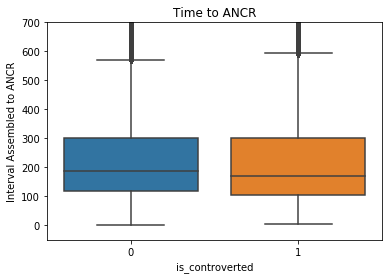

In [34]:
# This is a measure of how long it takes for the WCB board to consider the paperwork complete
# Does not appear to have much of a difference between controverted and not.

g = sns.boxplot(x='is_controverted', y='Interval Assembled to ANCR', data=df)
plt.title('Time to ANCR')
plt.ylim(-50, 700)


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


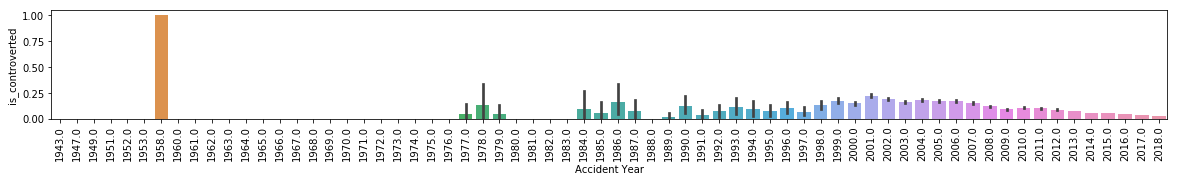

In [35]:
plt.figure(figsize=(20, 2))
sns.barplot(x='Accident Year', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


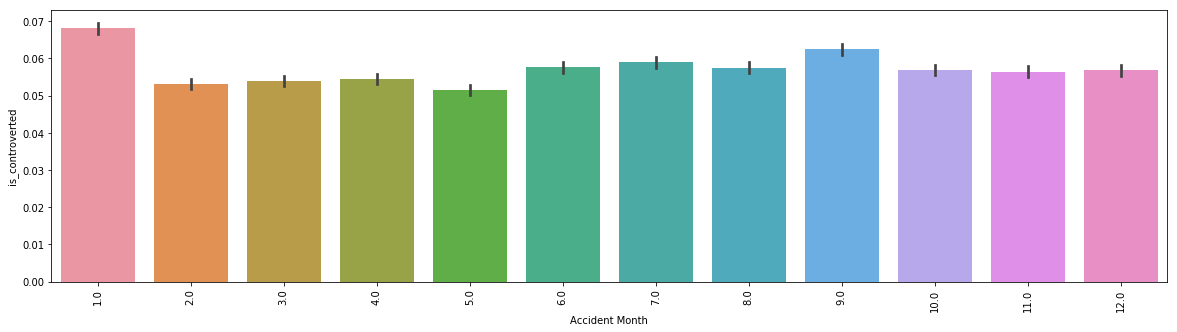

In [36]:
plt.figure(figsize=(20, 5))
sns.barplot(x='Accident Month', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

In [224]:
# Two proportions z-test looking at January vs the rest of the months
#https://www.statisticshowto.datasciencecentral.com/z-test/

check_jan = z_test(df, 'Accident Month', 1)
print('The z-value for a difference in january proportion compared to the ' +
      'population proportion is: {:.2f}'.format(check_jan))

Proportion Controverted Claims

1 proportion:0.07
Proportion others:0.06
Population proportion:0.06
The z-value for a difference in january proportion compared to the population proportion is: 16.30


This high z-value corresponds to a low p-value and means that the difference in proportion between a January accident being controverted and a claim in a different accident month being controverted is significant.

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


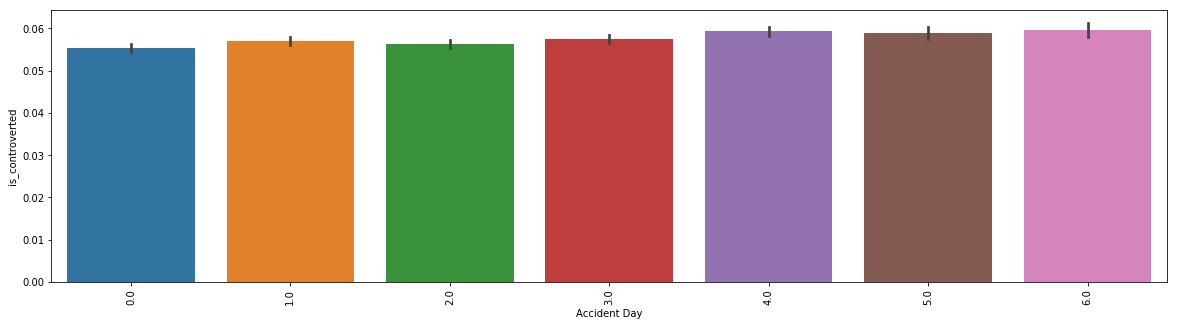

In [38]:
# Monday is 0, Sunday is 6
plt.figure(figsize=(20, 5))
sns.barplot(x='Accident Day', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


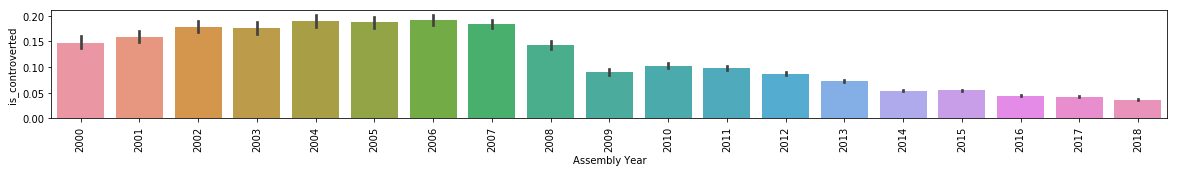

In [39]:
plt.figure(figsize=(20, 2))
sns.barplot(x='Assembly Year', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


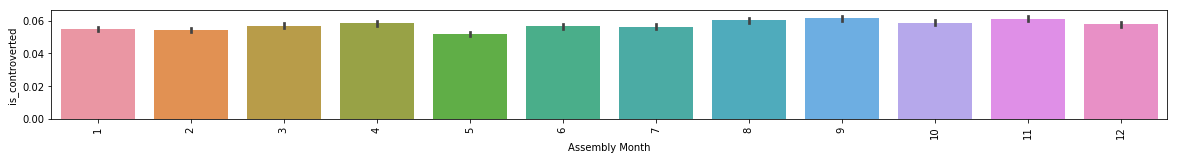

In [40]:
plt.figure(figsize=(20, 2))
sns.barplot(x='Assembly Month', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


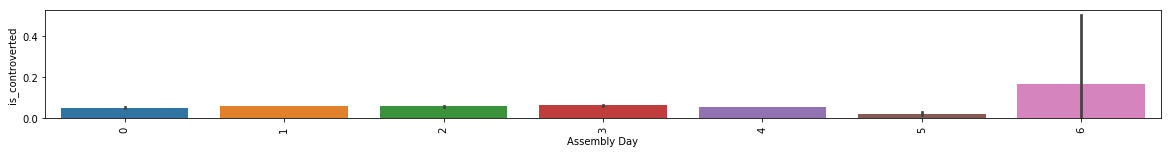

In [41]:
# This state employees are unlikely to be working on weekends (5 or 6)
plt.figure(figsize=(20, 2))
sns.barplot(x='Assembly Day', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

## Looking at the insurance carriers

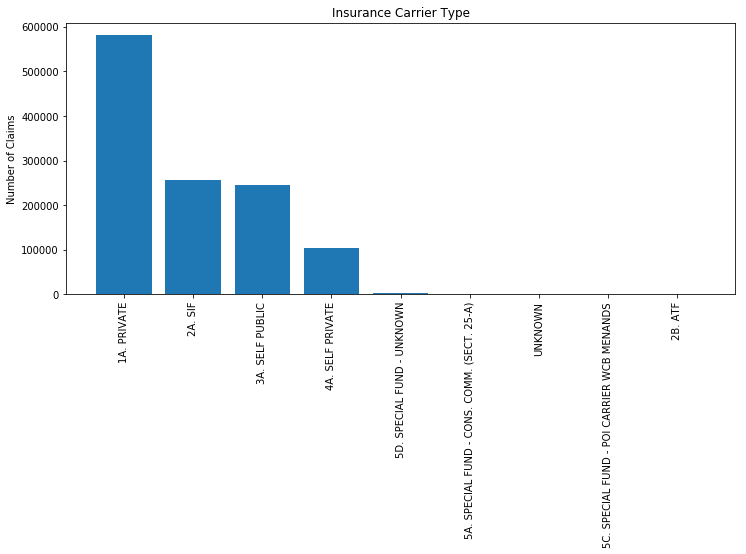

In [226]:
ins_types_plot = df.groupby(by='Carrier Type')['Carrier Type'].count()
ins_types_plot = ins_types_plot.sort_values(ascending=False)
plt.figure(figsize=(12, 5))
plt.bar(ins_types_plot.index, ins_types_plot)
plt.title('Insurance Carrier Type')
plt.ylabel('Number of Claims')
plt.xticks(rotation=90)

plt.show()

There are 1463 different insurance carriers.
State Insurance Fund is the largest carrier


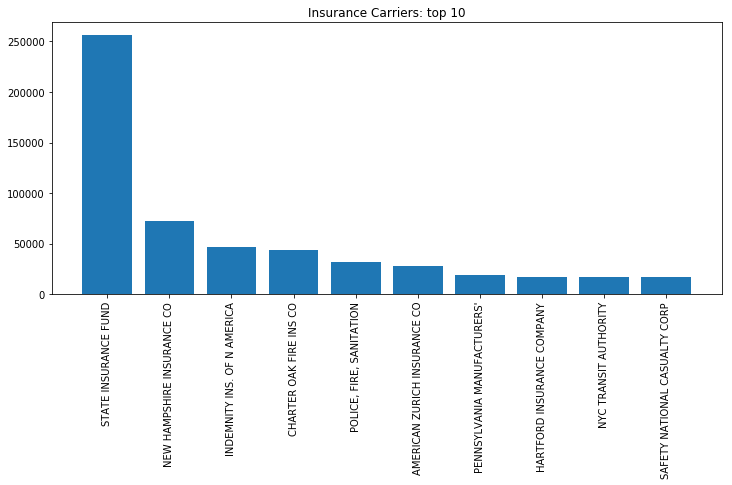

In [43]:
carrier_plot = df.groupby(by='Carrier Name')['Carrier Name'].count()
carrier_plot = carrier_plot.sort_values(ascending=False)[:10]
plt.figure(figsize=(12, 5))
plt.bar(carrier_plot.index, carrier_plot)
plt.xticks(rotation=90)
plt.title('Insurance Carriers: top 10')

print('There are {} different insurance carriers.'.format(len(df['Carrier Name'].unique())))
print('State Insurance Fund is the largest carrier')
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


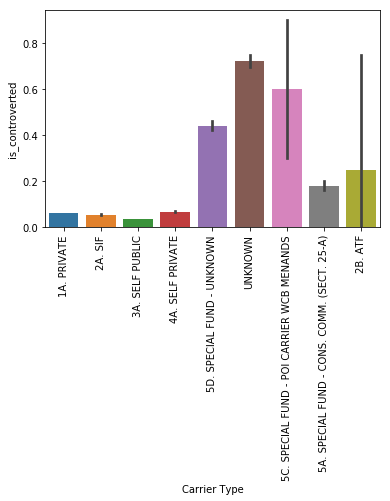

In [44]:
sns.barplot(x='Carrier Type', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


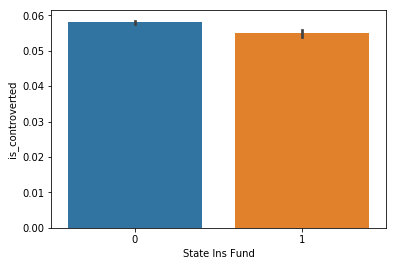

In [45]:
# Look at whether or not the state insurance fund has a higher/lower rate
# of controverted claims
sns.barplot(x='State Ins Fund', y='is_controverted', data=df)
plt.show()

In [46]:
# Check that all the State Ins funds are also the carrier type 2A. SIF
len(df[(df['State Ins Fund'] == 1) & (df['Carrier Type'] == '2A. SIF')]) / len(df[df['State Ins Fund'] == 1])

1.0

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


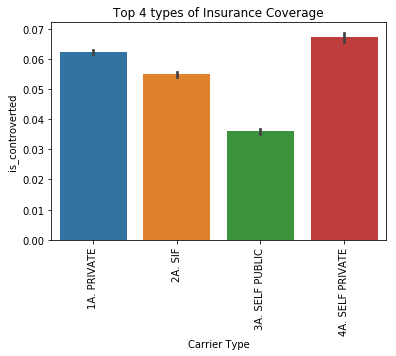

In [227]:
df_carrier = df[(df['Carrier Type'] == '1A. PRIVATE') | 
                (df['Carrier Type'] == '2A. SIF') | 
                (df['Carrier Type'] == '3A. SELF PUBLIC') | 
                (df['Carrier Type'] == '4A. SELF PRIVATE')] 
sns.barplot(x='Carrier Type', y='is_controverted', data=df_carrier)
plt.title('Top 4 types of Insurance Coverage')
plt.xticks(rotation=90)
plt.show()

In [57]:
# Check how many of the claims have a different type of insurance carrier than the 
# 4 main carriers
print('Number of claims with other insurance carriers: {}'.format(len(df) - len(df_carrier)))

Number of claims with insurance carrier other than 1A, 2A, 3A, or 4A: 5244


In [60]:
df['Carrier Type Group'] = df['Carrier Type']
df['Carrier Type Group'] = np.where((df['Carrier Type Group'] == '1A. PRIVATE') | 
                                      (df['Carrier Type Group'] == '2A. SIF') | 
                                      (df['Carrier Type Group'] == '3A. SELF PUBLIC') | 
                                      (df['Carrier Type Group'] == '4A. SELF PRIVATE'), 
                                      df['Carrier Type Group'], 'Other')


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


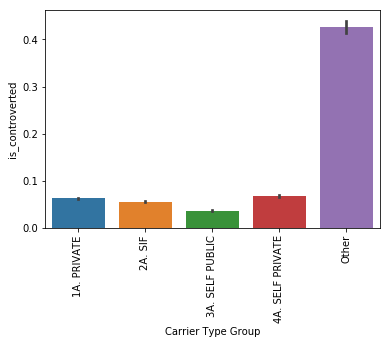

In [64]:
sns.barplot(x='Carrier Type Group', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

### Legal Representation

The fields in the file are updated over time.  This means that a lawyer can be secured after an insurance company has pushed back against a claim.  A strong indication this is occurring will be evident if the rate of controverted claims is significantly higher for claims with representation.  This will not be used in the modeling because I believe legal representation is an after effect of the claims being contested instead of an indicator that it will be contested.

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


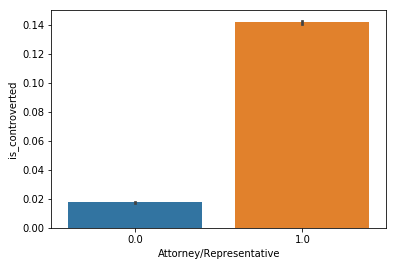

In [48]:
# Look at whether or not the state insurance fund has a higher/lower rate
# of controverted claims
sns.barplot(x='Attorney/Representative', y='is_controverted', data=df)
plt.show()

Most likely you get an attorney if you know your case is complicated, or maybe after it has already been controverted. No need for an attorney if the case is smooth.

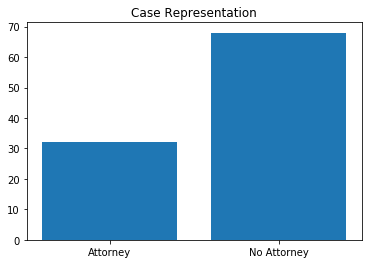

In [49]:
# Cases that are represented
perc_attorney = df['Attorney/Representative'].sum() / len(df['Attorney/Representative']) * 100
perc_none = 100 - perc_attorney
plt.bar(['Attorney','No Attorney'], [perc_attorney, perc_none])
plt.title('Case Representation')
plt.show()

Here we can see that the majority of the cases actually do not have legal representation.  

### Features for the model
The following features were selected for the model.  WCIO codes are used because this field is filled out more frequently than the alternate fields.  Gender, wage, and type of insurance is also considered. The accident and assembly dates are split into year, month, and day of the week since each of those variables appear to have an influence on whether or not the claim is controverted.  Time to ANCR is not used because it is essentially the difference between these dates and does not have much of an effect on whether or not the claim is controverted. 

In [65]:
features = ['Average Weekly Wage', 'Region', 'WCIO Part Of Body Code',
       'WCIO Nature of Injury Code', 'WCIO Cause of Injury Code', 
       'GenderNum', 'Accident Year', 'Accident Month', 'Accident Day', 
       'Assembly Year', 'Assembly Month', 'Assembly Day', 'Carrier Type Group', 'is_controverted']

In [74]:
def print_precision_recall(y_test, y_pred, description):
    print(description + ' precision score {:.3f}'.format(precision_score(y_test, y_pred)))
    print(description + ' recall score {:.3f}'.format(recall_score(y_test, y_pred)))
    print(description + ' Confusion Matrix: \n{}'.format(confusion_matrix(y_test, y_pred)))

##  Setting up training and testing sets
This next section splits the data in to test and training sets.  There are 3 different versions of training data sets here.  There is the regularly sampled training data set, an under sampled training set of the majority class and a SMOTE (synthetic oversampling) training set. 

In [279]:
df.isna().sum()

Claim Identifier                            0
Claim Type                                  0
District Name                               0
Average Weekly Wage                         0
Current Claim Status                        0
Claim Injury Type                           0
Age at Injury                               0
Assembly Date                               0
Accident Date                             538
ANCR Date                              584276
Controverted Date                     1121082
Section 32 Date                       1125688
PPD Scheduled Loss Date               1065974
PPD Non-Scheduled Loss Date           1144949
PTD Date                              1186516
First Appeal Date                     1127846
WCIO Part Of Body Code                      0
WCIO Part Of Body Description               0
WCIO Nature of Injury Code                  0
WCIO Nature of Injury Description           0
WCIO Cause of Injury Code                   0
WCIO Cause of Injury Description  

In [283]:
df_model = df[features].dropna(axis=0)

In [284]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1183074 entries, 0 to 1371344
Data columns (total 14 columns):
Average Weekly Wage           1183074 non-null float64
Region                        1183074 non-null object
WCIO Part Of Body Code        1183074 non-null object
WCIO Nature of Injury Code    1183074 non-null object
WCIO Cause of Injury Code     1183074 non-null object
GenderNum                     1183074 non-null int64
Accident Year                 1183074 non-null float64
Accident Month                1183074 non-null float64
Accident Day                  1183074 non-null float64
Assembly Year                 1183074 non-null int64
Assembly Month                1183074 non-null int64
Assembly Day                  1183074 non-null int64
Carrier Type Group            1183074 non-null object
is_controverted               1183074 non-null int64
dtypes: float64(4), int64(5), object(5)
memory usage: 135.4+ MB


In [248]:
# Set up training and test data sets
X = df_model[features]

# 
le = LabelEncoder()
X['Region'] = le.fit_transform(X['Region'])
X['WCIO Part Of Body Code'] = le.fit_transform(X['WCIO Part Of Body Code'])
X['WCIO Cause of Injury Code'] = le.fit_transform(X['WCIO Cause of Injury Code']) 
X['WCIO Nature of Injury Code'] = le.fit_transform(X['WCIO Nature of Injury Code'])
X['Carrier Type Group'] = le.fit_transform(X['Carrier Type Group'])

train, test = train_test_split(X, test_size=0.3)

num_controverted = train['is_controverted'].sum()

train_controverted = train[train['is_controverted'] == 1]
rand_not_controverted = train[train['is_controverted'] == 0].sample(num_controverted)

# Combine data
train_under = pd.concat([train[train['is_controverted'] == 1], rand_not_controverted])

# Show the ratio
print('Percent Controverted = {}'.format(train_under['is_controverted'].sum()/len(train_under['is_controverted'])))

# Undersampled training set
X_train_under = train_under.drop('is_controverted', axis=1)
y_train_under = train_under['is_controverted']

# Regular training set
X_train = train.drop('is_controverted', axis=1)
y_train = train['is_controverted']

# Test set, regularly sampled
X_test = test.drop('is_controverted', axis=1)
y_test = test['is_controverted']

# y_test is overwritten by other code, set an additional variable with a unique name for 
# graphing later
y_test_label = y_test 

# SMOTE - oversample the minority class
sm = SMOTE()
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)
X_train_SMOTE = pd.DataFrame(X_train_SMOTE, columns=X_train.columns)

Percent Controverted = 0.5


### Random Forest
- Fits a number of decision tree classifiers on sub-samples of the dataset.
- Less prone to overfitting than a decision tree
- Use label encoded data set
- Look at feature importances
- For handling the unbalanced dataset, try regular, under sampled, and SMOTE
- Regular sampling - good accuracy, poor recall
- Under sampled and SMOTE, overfit to data, high recall, low precision

In [249]:
# Initiate a Random Forest Class
rfc = RandomForestClassifier(n_estimators=50)

# Fit the model
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Look at the score for the training under sampled data
y_train_pred = rfc.predict(X_train)
print('\nThe score of the training set')
print('{:.3f}'.format(rfc.score(X_train, y_train)))
print('\nThe confusion matrix training set')
print(confusion_matrix(y_train, y_train_pred))

print('\nRandom Forest Score: {:.3f}'.format(rfc.score(X_test, y_test)))

print_precision_recall(y_test, y_pred, 'Random Forest')

# Use this for ROC curves later
y_pred_prob_rfc = rfc.predict_proba(X_test)[:, 1]


The score of the training set
0.999

The confusion matrix training set
[[781102     39]
 [   634  46376]]

Random Forest Score: 0.944
Random Forest precision score 0.590
Random Forest recall score 0.073
Random Forest Confusion Matrix: 
[[333579   1028]
 [ 18835   1481]]


This model is overfit to the data.  The training set is nearly perfectly matched, but the test set is not.

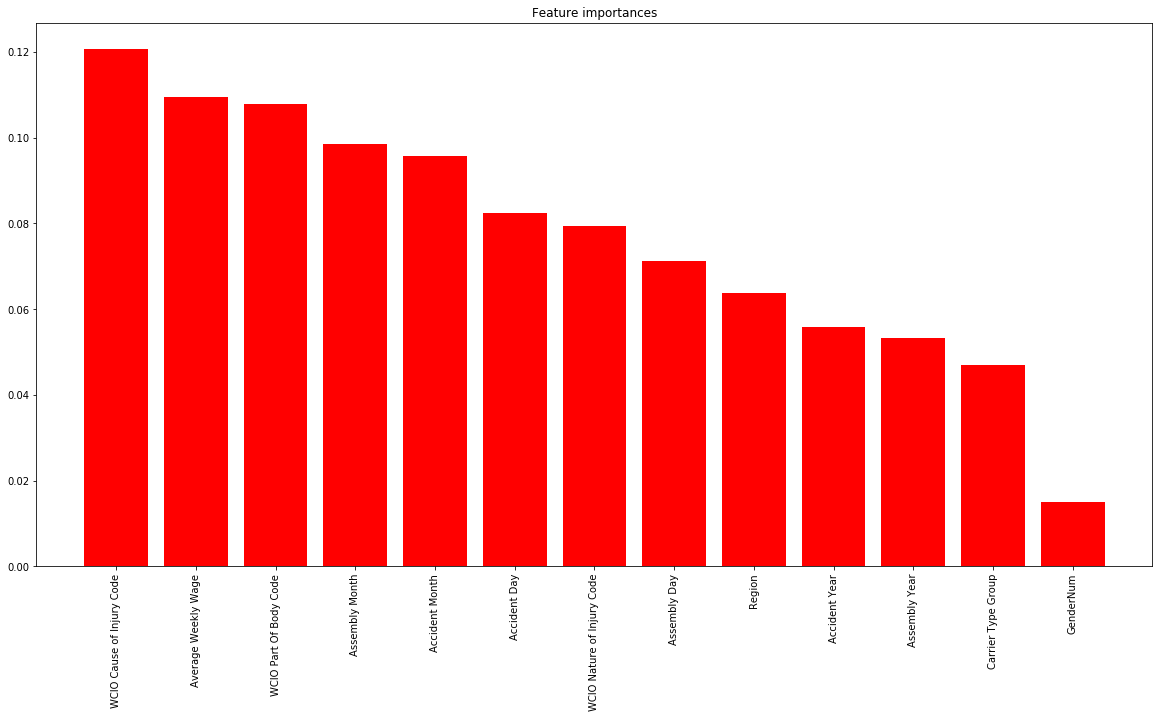

In [250]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.show()

In [251]:
# Under sampled data set
rfc_under = RandomForestClassifier(n_estimators=50)
rfc_under.fit(X_train_under, y_train_under)
y_pred_under = rfc_under.predict(X_test)

# Look at the score for the training under sampled data
y_train_under_pred = rfc.predict(X_train_under)
print('\nThe score of the undersampled training set')
print(rfc_under.score(X_train_under, y_train_under))
print('\nThe confusion matrix of undersampled training set')
print(confusion_matrix(y_train_under, y_train_under_pred))

print('\nRandom Forest Classifier Score: {:.3f}'.format(rfc_under.score(X_test, y_test)))

# Look at the confusion matrix for the test data points
print_precision_recall(y_test, y_pred_under, 'Random Forest Classifier Under Sampled')

# Use this for ROC curves later
y_pred_prob_rfc_under = rfc_under.predict_proba(X_test)[:, 1]


The score of the undersampled training set
0.9995745586045522

The confusion matrix of undersampled training set
[[47006     4]
 [  634 46376]]

Random Forest Classifier Score: 0.741
Random Forest Classifier Under Sampled precision score 0.142
Random Forest Classifier Under Sampled recall score 0.696
Random Forest Classifier Under Sampled Confusion Matrix: 
[[249010  85597]
 [  6172  14144]]


The high performance of the training set with almost no incorrectly classified data points indicates that the model is likely over-fitting.

In [252]:
# Random forest with SMOTE
rfc_SMOTE = RandomForestClassifier(n_estimators=50)
rfc_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_SMOTE = rfc_SMOTE.predict(X_test)

# Look at the score for the training under sampled data
y_train_SMOTE_pred = rfc.predict(X_train_SMOTE)
print('\nThe score of the undersampled training set')
print(rfc_SMOTE.score(X_train_SMOTE, y_train_SMOTE))
print('\nThe confusion matrix of undersampled training set')
print(confusion_matrix(y_train_SMOTE, y_train_SMOTE_pred))

print('\nRandom Forest Classifier Score: {:.3f}'.format(rfc_under.score(X_test, y_test)))

# Look at the confusion matrix for the test data points
print_precision_recall(y_test, y_pred_SMOTE, 'Random Forest Classifier SMOTE')

# Use this for ROC curves later
y_pred_prob_rfc_SMOTE = rfc_SMOTE.predict_proba(X_test)[:, 1]


The score of the undersampled training set
0.9996658733826543

The confusion matrix of undersampled training set
[[781102     39]
 [418715 362426]]

Random Forest Classifier Score: 0.741
Random Forest Classifier SMOTE precision score 0.521
Random Forest Classifier SMOTE recall score 0.077
Random Forest Classifier SMOTE Confusion Matrix: 
[[333160   1447]
 [ 18745   1571]]


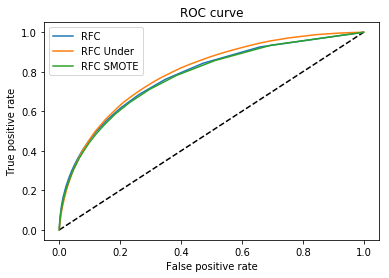

In [253]:
# Look at the ROC curves for each of the three forest models to see which of the sampling methods
# made the biggest difference or if they are the same

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_prob_rfc)
fpr_rfc_under, tpr_rfc_under, _ = roc_curve(y_test, y_pred_prob_rfc_under)
fpr_rfc_SMOTE, tpr_rfc_SMOTE, _ = roc_curve(y_test, y_pred_prob_rfc_SMOTE)

plt.plot(fpr_rfc, tpr_rfc, label='RFC')
plt.plot(fpr_rfc_under, tpr_rfc_under, label='RFC Under')
plt.plot(fpr_rfc_SMOTE, tpr_rfc_SMOTE, label='RFC SMOTE')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Between these three sampling techniques, for random forest, undersampling the majority class appears to give slightly better results than regular sampling or SMOTE.

## Gradient Boost Classifier

In [254]:
# Regular sampling
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

print('Gradient Boost Classifier')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

print('Score: {:.3f}'.format(gbc.score(X_test, y_test)))
print('Recall Score: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision Score: {:.3f}'.format(precision_score(y_test, y_pred)))

y_pred_prob_gbc = gbc.predict_proba(X_test)[:, 1]

Gradient Boost Classifier
Confusion Matrix
[[334060    547]
 [ 19426    890]]
Score: 0.944
Recall Score: 0.044
Precision Score: 0.619


In [255]:
# Under sample the majority class
gbc_under = GradientBoostingClassifier()
gbc_under.fit(X_train_under, y_train_under)
gbc_under.score(X_test, y_test)
y_pred_under = gbc_under.predict(X_test)

print('Under Sample Majority Class')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_under))

print('Score: {:.3f}'.format(gbc_under.score(X_test, y_test)))
print('Recall Score: {:.3f}'.format(recall_score(y_test, y_pred_under)))
print('Precision Score: {:.3f}'.format(precision_score(y_test, y_pred_under)))

y_pred_prob_gbc_under = gbc_under.predict_proba(X_test)[:, 1]

Under Sample Majority Class
Confusion Matrix
[[250680  83927]
 [  6460  13856]]
Score: 0.745
Recall Score: 0.682
Precision Score: 0.142


In [256]:
gbc_SMOTE = GradientBoostingClassifier()
gbc_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)
gbc_SMOTE.score(X_test, y_test)
y_pred_SMOTE = gbc_SMOTE.predict(X_test)

print('SMOTE')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_SMOTE))

print('Score: {:.3f}'.format(gbc_SMOTE.score(X_test, y_test)))
print('Recall Score: {:.3f}'.format(recall_score(y_test, y_pred_SMOTE)))
print('Precision Score: {:.3f}'.format(precision_score(y_test, y_pred_SMOTE)))

y_pred_prob_gbc_SMOTE = gbc_SMOTE.predict_proba(X_test)[:, 1]

SMOTE
Confusion Matrix
[[333095   1512]
 [ 19291   1025]]
Score: 0.941
Recall Score: 0.050
Precision Score: 0.404


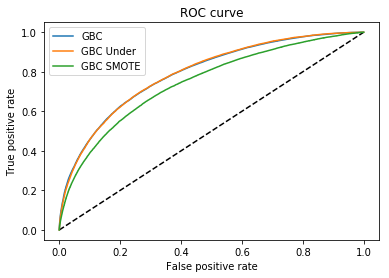

In [257]:
# Look at the ROC curves for each of the three forest models to see which of the sampling methods
# made the biggest difference or if they are the same

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_prob_gbc)
fpr_gbc_under, tpr_gbc_under, _ = roc_curve(y_test, y_pred_prob_gbc_under)
fpr_gbc_SMOTE, tpr_gbc_SMOTE, _ = roc_curve(y_test, y_pred_prob_gbc_SMOTE)

plt.plot(fpr_gbc, tpr_gbc, label='GBC')
plt.plot(fpr_gbc_under, tpr_gbc_under, label='GBC Under')
plt.plot(fpr_gbc_SMOTE, tpr_gbc_SMOTE, label='GBC SMOTE')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Light Gradient Boosting
- Grows models leaf-wise instead of depth
- Computationally less expensive than Gradient Boosting
- Can handle categorical variables label encoded
- Use Regular dataset, undersampled, and SMOTE
- All three performed about the same, use the under sampled data because it is less computationally expensive

This article was very helpful for how to do it https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc <br>
Light Gradient Boosting Parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html <br>
            Parameter Tuning: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html <br>

In [258]:
# Need to declare categorical variables
# Also tried it with the date variables encoded as categorical, not much of a model difference
categorical = ['Region', 'WCIO Part Of Body Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 
               'GenderNum', 'Carrier Type Group']
d_train = lgbm.Dataset(X_train, label=y_train, categorical_feature=categorical)

params = {'boosting_type': 'gbdt', # Model gets worse with random forest
          'objective': 'binary', # Classification problem
          'metric': 'binary_logloss', # Classification
          'sub_feature': 0.5, # Percentage of features to select, avoid overfitting
          'num_leaves': 30, # Number of leaves in model, model worsens if decreased
          'min_data_in_leaf': 55, # Default is 20, minimum number of data points in leaf to avoid overfitting
          'learning_rate': 0.1} 

clf = lgbm.train(params, d_train, num_boost_round=200)

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [259]:
# Output is a list of probabilities, convert to 0 or 1
#Prediction
y_pred_proba_lgbm = clf.predict(X_test)
#convert into binary values
y_pred = y_pred_proba_lgbm
y_pred = np.where(y_pred >=0.5, 1, 0)

print('Light Gradient Boost')
print(confusion_matrix(y_test, y_pred))

accuracy=accuracy_score(y_test, y_pred)
print('Accuracy Score LightGBM: {:.3f}'.format(accuracy))
print('Recall Score: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision Score: {:.3f}'.format(precision_score(y_test, y_pred)))

Light Gradient Boost
[[333675    932]
 [ 18584   1732]]
Accuracy Score LightGBM: 0.945
Recall Score: 0.085
Precision Score: 0.650


In [260]:
# Undersample majority class
categorical = ['Region', 'WCIO Part Of Body Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 
               'GenderNum', 'Carrier Type Group']
d_train = lgbm.Dataset(X_train_under, label=y_train_under, categorical_feature=categorical)

params = {'boosting_type': 'gbdt', # Model gets worse with random forest
          'objective': 'binary', # Classification problem
          'metric': 'binary_logloss', # Classification
          'sub_feature': 0.5, # Percentage of features to select, avoid overfitting
          'num_leaves': 30, # Number of leaves in model, model worsens if decreased
          'min_data_in_leaf': 55, # Default is 20, minimum number of data points in leaf to avoid overfitting
          'learning_rate': 0.1} 

clf_under = lgbm.train(params, d_train, num_boost_round=200)

# Output is a list of probabilities, convert to 0 or 1
#Prediction
y_pred_proba_lgbm_under = clf_under.predict(X_test)
#convert into binary values
y_pred = y_pred_proba_lgbm_under
y_pred = np.where(y_pred >=0.5, 1, 0)

print('Light Gradient Boost')
print(confusion_matrix(y_test, y_pred))

accuracy=accuracy_score(y_test, y_pred)
print('Accuracy Score LightGBM: {:.3f}'.format(accuracy))
print('Recall Score: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision Score: {:.3f}'.format(precision_score(y_test, y_pred)))

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Light Gradient Boost
[[253096  81511]
 [  5419  14897]]
Accuracy Score LightGBM: 0.755
Recall Score: 0.733
Precision Score: 0.155


In [261]:
# Repeat with SMOTE
d_train = lgbm.Dataset(X_train_SMOTE, label=y_train_SMOTE, categorical_feature=categorical)

params = {'boosting_type': 'gbdt', # Model gets worse with random forest
          'objective': 'binary', # Classification problem
          'metric': 'binary_logloss', # Classification
          'sub_feature': 0.5, # Percentage of features to select, avoid overfitting
          'num_leaves': 30, # Number of leaves in model, model worsens if decreased
          'min_data_in_leaf': 55, # Default is 20, minimum number of data points in leaf to avoid overfitting
          'learning_rate': 0.1} 

clf_SMOTE = lgbm.train(params, d_train, num_boost_round=200)

# Output is a list of probabilities, convert to 0 or 1
#Prediction
y_pred_proba_lgbm_SMOTE = clf_SMOTE.predict(X_test)
#convert into binary values
y_pred = y_pred_proba_lgbm_SMOTE
y_pred = np.where(y_pred >=0.5, 1, 0)

print('Light Gradient Boost: SMOTE')
print(confusion_matrix(y_test, y_pred))

accuracy=accuracy_score(y_test, y_pred)
print('Accuracy Score LightGBM: {:.3f}'.format(accuracy))
print('Recall Score: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision Score: {:.3f}'.format(precision_score(y_test, y_pred)))

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Light Gradient Boost: SMOTE
[[333535   1072]
 [ 18618   1698]]
Accuracy Score LightGBM: 0.945
Recall Score: 0.084
Precision Score: 0.613


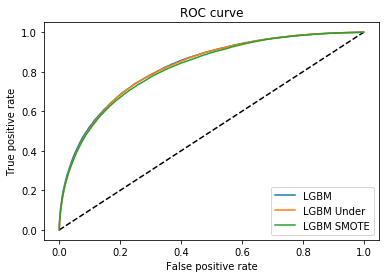

In [262]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
fpr_lgbm_under, tpr_lgbm_under, _ = roc_curve(y_test, y_pred_proba_lgbm_under)
fpr_lgbm_SMOTE, tpr_lgbm_SMOTE, _ = roc_curve(y_test, y_pred_proba_lgbm_SMOTE)

plt.plot(fpr_lgbm, tpr_lgbm, label='LGBM')
plt.plot(fpr_lgbm_under, tpr_lgbm_under, label='LGBM Under')
plt.plot(fpr_lgbm_SMOTE, tpr_lgbm_SMOTE, label='LGBM SMOTE')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Logistic Regression 
- One hot encode categorical features
- Lasso regression: number of features is > 200 after one hot encoding
- SMOTE does not work well on this number of features
    - Slow
    - NAN with one hot categorical
    - also tried using SMOTENC - too many categorical features
    - Ultimately did not select this model, so did not pursue SMOTE
- Try undersampling majority class and using all data points
- Select K Best to reduce features ahead of times

Try lasso regression due to the number of features.  

In [263]:
# Categorical features that need to be one hot encoded
cat_features = ['Region', 'WCIO Part Of Body Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 
                'Carrier Type Group']

# Use pd.get dummies to one hot encode
one_hot = pd.get_dummies(df_model[cat_features])


# List of featurest that are not one hot encoded by this
features_not_one_hot = ['Average Weekly Wage', 'GenderNum', 'Assembly Year', 'Assembly Month', 'Assembly Day', 
                         'Accident Year', 'Accident Month', 'Accident Day', 'is_controverted']
# Join the one hot encoded features back to the other variables
df_enc = one_hot.join(df_model[features_not_one_hot])
df_enc.head()

# Split train and test data
train, test = train_test_split(df_enc, test_size=0.3)

# Total number of controverted claims in the training data set
num_controverted = train['is_controverted'].sum()

# Select all the controverted claims, and equal number of not controverted ones
# This undersamples the majority class
train_controverted = train[train['is_controverted'] == 1]
rand_not_controverted = train[train['is_controverted'] == 0].sample(num_controverted)

# Combine data
train_under = pd.concat([train[train['is_controverted'] == 1], rand_not_controverted])

# Show the ratio
print('Percent Controverted = {}'.format(train_under['is_controverted'].sum()/
                                         len(train_under['is_controverted'])))

# Undersampled training set
X_train_under_one = train_under.drop('is_controverted', axis=1)
y_train_under_one = train_under['is_controverted']

# Regular training set
X_train_one = train.drop('is_controverted', axis=1)
y_train_one = train['is_controverted']

# Test set, regularly sampled
X_test_one = test.drop('is_controverted', axis=1)
y_test_one = test['is_controverted']

# Too many categorical variables for SMOTENC
# SMOTE - oversample the minority class
#sm = SMOTENC(categorical_features=list(one_hot.columns))
#X_train_SMOTE_one, y_train_SMOTE_one = sm.fit_resample(X_train_one, y_train_one)
#X_train_SMOTE_one = pd.DataFrame(X_train_SMOTE, columns=X_train_one.columns)

Percent Controverted = 0.5


In [264]:
# Check the one hot encoding
X_train_under_one.head()

,Region_Capital District,Region_Central New York,Region_Finger Lakes,Region_Hudson Valley,Region_Long Island,Region_Mohawk Valley,Region_New York City,Region_North Country,Region_Southern Tier,Region_Western New York,...,Carrier Type Group_4A. SELF PRIVATE,Carrier Type Group_Other,Average Weekly Wage,GenderNum,Assembly Year,Assembly Month,Assembly Day,Accident Year,Accident Month,Accident Day
397103,0,0,0,0,0,0,1,0,0,0,...,0,0,0.00,1,2016,12,0,2016.0,11.0,2.0
1078597,0,0,0,0,0,1,0,0,0,0,...,0,0,0.00,0,2017,4,1,2017.0,4.0,4.0
759895,0,0,0,0,0,0,1,0,0,0,...,0,0,405.53,0,2014,7,1,2013.0,5.0,2.0
471842,1,0,0,0,0,0,0,0,0,0,...,0,0,478.38,0,2012,6,1,2012.0,7.0,2.0
391467,0,0,0,0,0,0,1,0,0,0,...,0,0,1027.32,1,2017,1,2,2016.0,10.0,2.0


In [265]:
X_train_under_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94536 entries, 397103 to 1160739
Columns: 209 entries, Region_Capital District to Accident Day
dtypes: float64(4), int64(4), uint8(201)
memory usage: 24.6 MB


In [266]:
lr = LogisticRegression(penalty='l2', solver='liblinear', C=0.5)
lr.fit(X_train_one, y_train_one)
y_pred_lr = lr.predict(X_test_one)
y_train_pred_lr = lr.predict(X_train_one)

print('\nThe score of the training set')
print(lr.score(X_train_one, y_train_one))
print('\nThe confusion matrix of training set')
print(confusion_matrix(y_train_one, y_train_pred_lr))

print('\nLogistic Regression Score: {:.3f}'.format(lr.score(X_test_one, y_test_one)))

# Look at the confusion matrix for the test data points
print_precision_recall(y_test_one, y_pred_lr, 'Logistic Regression')

# Use this for ROC curves later
y_pred_prob_lr = lr.predict_proba(X_test_one)[:, 1]


The score of the training set
0.9427809662730589

The confusion matrix of training set
[[780460    423]
 [ 46963    305]]

Logistic Regression Score: 0.943
Logistic Regression precision score 0.413
Logistic Regression recall score 0.006
Logistic Regression Confusion Matrix: 
[[334700    165]
 [ 19942    116]]


In [267]:
lr_under = LogisticRegression(penalty='l2', solver='liblinear', C=0.5)
lr_under.fit(X_train_under_one, y_train_under_one)
y_pred_lr_under = lr_under.predict(X_test_one)
y_train_pred_lr_under = lr_under.predict(X_train_under_one)

print('\nThe score of the training set')
print(lr_under.score(X_train_under_one, y_train_under_one))
print('\nThe confusion matrix of training set')
print(confusion_matrix(y_train_under_one, y_train_pred_lr_under))

print('\nLogistic Regression Score: {:.3f}'.format(lr_under.score(X_test_one, y_test_one)))

# Look at the confusion matrix for the test data points
print_precision_recall(y_test_one, y_pred_lr_under, 'Logistic Regression Under Sampled')


y_pred_prob_lr_under = lr_under.predict_proba(X_test_one)[:,1]

print('Log-Loss: {:.3f}'.format(log_loss(y_test_one, y_pred_prob_lr_under)))


The score of the training set
0.7036049758822036

The confusion matrix of training set
[[34296 12972]
 [15048 32220]]

Logistic Regression Score: 0.721
Logistic Regression Under Sampled precision score 0.129
Logistic Regression Under Sampled recall score 0.681
Logistic Regression Under Sampled Confusion Matrix: 
[[242366  92499]
 [  6400  13658]]
Log-Loss: 0.567


## Select K Best
- Checked to see if model improved with reducing features down from > 200
- If better, then can optimize which features, perform more feature engineering
- ROC curve shows under sampling with all one hot encoded features better

In [268]:
# Categorical features that need to be one hot encoded
cat_features = ['Region', 'WCIO Part Of Body Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 
                'Carrier Type Group']

# Use pd.get dummies to one hot encode
one_hot = pd.get_dummies(df_model[cat_features])


# List of featurest that are not one hot encoded by this
features_not_one_hot = ['Average Weekly Wage', 'GenderNum', 'Assembly Year', 'Assembly Month', 'Assembly Day', 
                         'Accident Year', 'Accident Month', 'Accident Day', 'is_controverted']
# Join the one hot encoded features back to the other variables
df_enc = one_hot.join(df_model[features_not_one_hot])
df_enc.head()

# Split train and test data
train, test = train_test_split(df_enc, test_size=0.3)

X = train.drop('is_controverted', axis=1)
y = train['is_controverted']

skb = SelectKBest(chi2, k=30)
x_new = skb.fit_transform(X, y)

mask = skb.get_support()
new_features = X.columns[mask]


In [269]:
print(new_features)

Index(['Region_New York City', 'WCIO Part Of Body Code_13',
       'WCIO Part Of Body Code_36', 'WCIO Part Of Body Code_49',
       'WCIO Part Of Body Code_60', 'WCIO Part Of Body Code_90',
       'WCIO Part Of Body Code_91', 'WCIO Cause of Injury Code_52',
       'WCIO Cause of Injury Code_60', 'WCIO Cause of Injury Code_82',
       'WCIO Cause of Injury Code_90', 'WCIO Cause of Injury Code_97',
       'WCIO Cause of Injury Code_98', 'WCIO Cause of Injury Code_99',
       'WCIO Nature of Injury Code_10', 'WCIO Nature of Injury Code_31',
       'WCIO Nature of Injury Code_40', 'WCIO Nature of Injury Code_41',
       'WCIO Nature of Injury Code_43', 'WCIO Nature of Injury Code_59',
       'WCIO Nature of Injury Code_61', 'WCIO Nature of Injury Code_65',
       'WCIO Nature of Injury Code_71', 'WCIO Nature of Injury Code_72',
       'WCIO Nature of Injury Code_77', 'WCIO Nature of Injury Code_78',
       'WCIO Nature of Injury Code_80', 'Carrier Type Group_3A. SELF PUBLIC',
       'Carri

In [270]:
X_test = test[new_features]
y_test2 = test['is_controverted']

lr = LogisticRegression(penalty='l2', solver='liblinear', C=0.5)
lr.fit(x_new, y)
y_pred_lr = lr.predict(X_test)
y_train_pred_lr = lr.predict(x_new)

print('\nThe score of the training set')
print(lr.score(x_new, y))
print('\nThe confusion matrix of training set')
print(confusion_matrix(y, y_train_pred_lr))

print('\nLogistic Regression Score: {:.3f}'.format(lr.score(X_test, y_test2)))

# Look at the confusion matrix for the test data points
print_precision_recall(y_test2, y_pred_lr, 'Logistic Regression')

# Use this for ROC curves later
y_pred_prob_lr_k = lr.predict_proba(X_test)[:, 1]


The score of the training set
0.9426747054583041

The confusion matrix of training set
[[779496   1370]
 [ 46104   1181]]

Logistic Regression Score: 0.943
Logistic Regression precision score 0.457
Logistic Regression recall score 0.023
Logistic Regression Confusion Matrix: 
[[334340    542]
 [ 19585    456]]


In [271]:
#lr_SMOTE = LogisticRegression(penalty='l2', solver='lbfgs')
#lr_SMOTE.fit(X_train_SMOTE_one, y_train_SMOTE_one)
#y_pred_lr_SMOTE = lr_SMOTE.predict(X_test_one)
#y_train_pred_lr_SMOTE = lr_SMOTE.predict(X_train_SMOTE_one)

#print('\nThe score of the training set')
#print(lr_SMOTE.score(X_train_SMOTE_one, y_train_SMOTE_one))
#print('\nThe confusion matrix of training set')
#print(confusion_matrix(y_train_SMOTE_one, y_train_pred_lr_SMOTE))

#print('\nLogistic Regression Score: {:.3f}'.format(lr.score(X_test_one, y_test_one)))

# Look at the confusion matrix for the test data points
#print_precision_recall(y_test_one, y_pred_lr_SMOTE, 'Logistic Regression Under Sampled')


#y_pred_prob_lr_SMOTE = lr_SMOTE.predict_proba(X_test_one)[:,1]
#print('Log-Loss: {:.3f}'.format(log_loss(y_test_one, y_pred_prob_lr_SMOTE)))

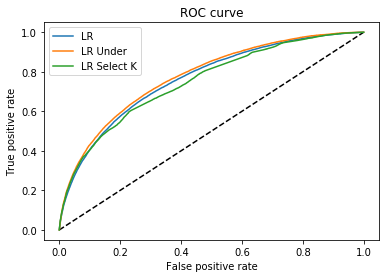

In [275]:
# Look at the ROC curves for each of the three forest models to see which of the sampling methods
# made the biggest difference or if they are the same

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
fpr_lr, tpr_lr, _ = roc_curve(y_test_one, y_pred_prob_lr)
fpr_lr_under, tpr_lr_under, _ = roc_curve(y_test_one, y_pred_prob_lr_under)
fpr_lr_k, tpr_lr_k, _ = roc_curve(y_test2, y_pred_prob_lr_k)
#fpr_lr_SMOTE, tpr_lr_SMOTE, _ = roc_curve(y_test, y_pred_prob_lr_SMOTE)

plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_lr_under, tpr_lr_under, label='LR Under')
plt.plot(fpr_lr_k, tpr_lr_k, label='LR Select K')
#plt.plot(fpr_lr_SMOTE, tpr_lr_SMOTE, label='LR SMOTE')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Model Selection

The LightGBM ROC curve is the furthest to the left.  This means that this model has the best true positive rate to false positive rate and will best identify the controverted claims in this data set. As a result, this is the model that I will be optimizing.

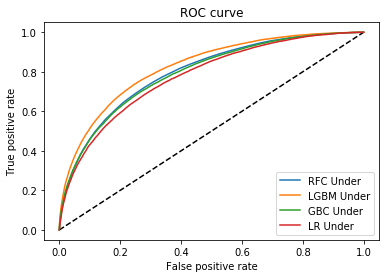

In [277]:
# Look at the ROC curves for each of the three forest models to see which of the sampling methods
# made the biggest difference or if they are the same

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

# Use the unique names for y_test here to make sure they don't plot against the
# wrong x axis labels
fpr_rfc_under, tpr_rfc_under, _ = roc_curve(y_test_label, y_pred_prob_rfc_under)
fpr_lr_under, tpr_lr_under, _ = roc_curve(y_test_one, y_pred_prob_lr_under)
fpr_lgbm_under, tpr_lgbm_under, _ = roc_curve(y_test_label, y_pred_proba_lgbm_under)
fpr_gbc_under, tpr_gbc_under, _ = roc_curve(y_test_label, y_pred_prob_gbc_under)

plt.plot(fpr_rfc_under, tpr_rfc_under, label='RFC Under')
plt.plot(fpr_lgbm_under, tpr_lgbm_under, label='LGBM Under')
plt.plot(fpr_gbc_under, tpr_gbc_under, label='GBC Under')
plt.plot(fpr_lr_under, tpr_lr_under, label='LR Under')


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [285]:
# Set up training and test data sets
# Label encode again, some parameters overwritten by logistic regression one hot
X = df_model[features]

# 
le = LabelEncoder()
X['Region'] = le.fit_transform(X['Region'])
X['WCIO Part Of Body Code'] = le.fit_transform(X['WCIO Part Of Body Code'])
X['WCIO Cause of Injury Code'] = le.fit_transform(X['WCIO Cause of Injury Code']) 
X['WCIO Nature of Injury Code'] = le.fit_transform(X['WCIO Nature of Injury Code'])
X['Carrier Type Group'] = le.fit_transform(X['Carrier Type Group'])

train, test = train_test_split(X, test_size=0.3)

num_controverted = train['is_controverted'].sum()

train_controverted = train[train['is_controverted'] == 1]
rand_not_controverted = train[train['is_controverted'] == 0].sample(num_controverted)

# Combine data
train_under = pd.concat([train[train['is_controverted'] == 1], rand_not_controverted])

# Show the ratio
print('Percent Controverted = {}'.format(train_under['is_controverted'].sum()/len(train_under['is_controverted'])))

# Undersampled training set
X_train_under = train_under.drop('is_controverted', axis=1)
y_train_under = train_under['is_controverted']

# Regular training set
X_train = train.drop('is_controverted', axis=1)
y_train = train['is_controverted']

# Test set, regularly sampled
X_test = test.drop('is_controverted', axis=1)
y_test = test['is_controverted']


Percent Controverted = 0.5


In [286]:
# Undersample majority class
categorical = ['Region', 'WCIO Part Of Body Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 
               'GenderNum', 'Carrier Type Group']
d_train = lgbm.Dataset(X_train_under, label=y_train_under, categorical_feature=categorical)

params = {'boosting_type': 'gbdt', # Model gets worse with random forest
          'objective': 'binary', # Classification problem
          'metric': 'binary_logloss', # Classification
          'sub_feature': 0.4, # Percentage of features to select, avoid overfitting
          'num_leaves': 40, # Number of leaves in model, model worsens if decreased
          'min_data_in_leaf': 80, # Default is 20, minimum number of data points in leaf to avoid overfitting
          'learning_rate': 0.1,
          'bagging_fraction': 0.7,
          'bagging_freq': 12} 

clf_under = lgbm.train(params, d_train, num_boost_round=350)

# Output is a list of probabilities, convert to 0 or 1
#Prediction
y_pred_proba_lgbm_under = clf_under.predict(X_test)
#convert into binary values
y_pred = y_pred_proba_lgbm_under
y_pred = np.where(y_pred >=0.5, 1, 0)

print('Light Gradient Boost')
print(confusion_matrix(y_test, y_pred))

accuracy=accuracy_score(y_test, y_pred)
print('Accuracy Score LightGBM: {:.3f}'.format(accuracy))
print('Recall Score: {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision Score: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Log-Loss: {:.3f}'.format(log_loss(y_test, y_pred_proba_lgbm_under)))

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Light Gradient Boost
[[253783  80995]
 [  5250  14895]]
Accuracy Score LightGBM: 0.757
Recall Score: 0.739
Precision Score: 0.155
Log-Loss: 0.510


###  Cross Validation LGBM
- Check what the log-loss is when training set split into 5 folds
- Look at STD to see if much deviation between the log-loss
    - Found a low STD, the difference between the log-loss in folds was low
- Use to determine over-fit to part of the training set
- Early stopping

How to perform k-fold: https://www.kaggle.com/aharless/trying-to-do-k-fold-cv-on-lightgbm

In [291]:
d_train = lgbm.Dataset(X_train_under, label=y_train_under, categorical_feature=categorical)

# Cross validation
cv_results = lgbm.cv(
        params,
        d_train,
        num_boost_round=700,
        nfold=5,
        stratified=True, #This is default
        verbose_eval=20, 
        early_stopping_rounds=40)

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	cv_agg's binary_logloss: 0.563911 + 0.00131524
[40]	cv_agg's binary_logloss: 0.535065 + 0.00208858
[60]	cv_agg's binary_logloss: 0.52773 + 0.00224641
[80]	cv_agg's binary_logloss: 0.521768 + 0.002078
[100]	cv_agg's binary_logloss: 0.518838 + 0.00225853
[120]	cv_agg's binary_logloss: 0.516313 + 0.00234827
[140]	cv_agg's binary_logloss: 0.515876 + 0.00259286
[160]	cv_agg's binary_logloss: 0.514676 + 0.00280181
[180]	cv_agg's binary_logloss: 0.514442 + 0.00279502
[200]	cv_agg's binary_logloss: 0.513846 + 0.002802
[220]	cv_agg's binary_logloss: 0.513601 + 0.00272707
[240]	cv_agg's binary_logloss: 0.513081 + 0.00279089
[260]	cv_agg's binary_logloss: 0.512833 + 0.00266831
[280]	cv_agg's binary_logloss: 0.512954 + 0.00262896


In [290]:
# Display results
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['binary_logloss-mean']))
print('Best CV score: {:.3f}'.format(cv_results['binary_logloss-mean'][-1]))
print('Standard Deviation of Best CV Score: {:3f}'.format(cv_results['binary_logloss-stdv'][-1]))

Current parameters:
 {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary_logloss', 'sub_feature': 0.4, 'num_leaves': 40, 'min_data_in_leaf': 80, 'learning_rate': 0.1, 'bagging_fraction': 0.7, 'bagging_freq': 12}

Best num_boost_round: 253
Best CV score: 0.513
Standard Deviation of Best CV Score: 0.002738


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Carrier Type Group', 'GenderNum', 'Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


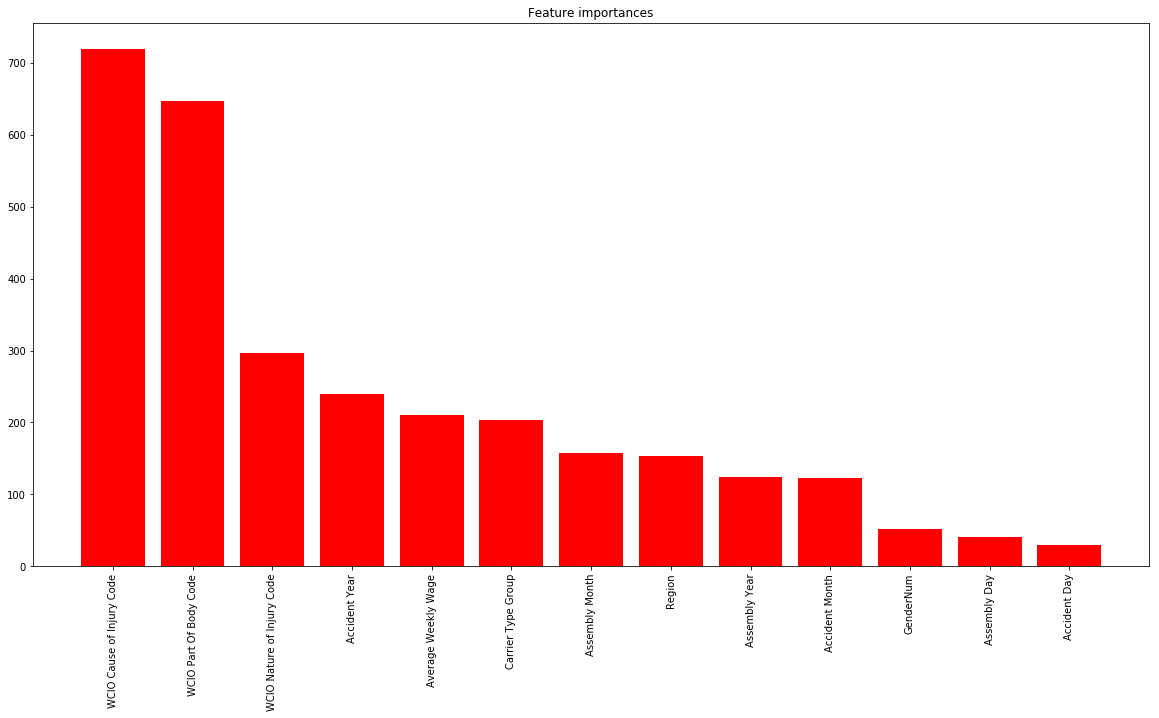

In [292]:
# This is not the winning model, but similar
# Slightly different implementation of LightGBM
# Look at what features are important from light gbm
from lightgbm import LGBMClassifier
          
lgbm2 = LGBMClassifier()
lgbm2.fit(X_train_under, y_train_under, categorical_feature=categorical)

importances = lgbm2.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.show()

### How I Optimized Parameters
- Set up a grid search
- Did larger ranges for paramters at different times for computational reasons
- Narrowed down to di

In [221]:
# A couple of functions to desplay the parameters and current scores
def print_params(frac, num, leaves, b_fract, freq, rate):
     print('frac: {}, num: {}, leaves: {}, b_frac: {},'.format(frac, num, leaves, b_fract) + 
           ' freq: {}, rate: {}'.format(freq, rate))
        
def print_scores(y_test, y_pred):
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    # Precision
    prec = precision_score(y_test, y_pred) 
    # Recall
    recall = recall_score(y_test, y_pred)
    print('Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}'.format(acc, prec, recall))
    
    return acc, prec, recall

The following is a grid search.  First I did smaller grid searches on each of the parameters to get an idea of appropriate ranges.  This grid search could be expanded with more computational power and time. I did find that although I could improve the model somewhat, the accuracy and precision generally stayed within 1-2 percentage points.

In [115]:
sub_feature = np.arange(0.4, 1.1, 0.25)
min_data_leaf = np.arange(5, 105, 25)
bagging_fraction = np.arange(0.7, 1.1, 0.3)
# Not very sensative to changes in this parameter
bagging_freq = [7, 12]
# learning rate of 0.1 to 0.25 seems about the same
learning_rate = np.arange(0.1, 0.30, 0.15)
# Ran several times, best num_leaves appears to be 30, 40
num_leaves = np.arange(30, 50, 10)
# 100 and 200 rounds give same answers
rounds = [100, 200]
attempts = []

for frac in sub_feature:
    for leaves in min_data_leaf:
        for b_fract in bagging_fraction:
            for freq in bagging_freq:
                for rate in learning_rate:
                    for num in num_leaves:
                        for num_round in rounds:
                            params = {}
                            params['boosting_type'] = 'gbdt'
                            params['objective'] = 'binary'
                            params['metric'] = 'binary_logloss'
                            params['sub_feature'] = frac
                            params['num_leaves'] = num
                            params['min_data_in_leaf'] = leaves
                            params['bagging_fraction'] = b_fract
                            params['bagging_freq'] = freq
                            params['learning_rate'] = rate
                            
                            # Need to re-initialize d_train each time or set free data = False
                            d_train = lgbm.Dataset(X_train_under, label=y_train_under, categorical_feature=categorical)
                            clf = lgbm.train(params, d_train, num_boost_round=num_round)

                            y_pred_proba_lgbm = clf.predict(X_test)
                            #convert into binary values
                            y_pred = y_pred_proba_lgbm
                            y_pred = np.where(y_pred >=0.5, 1, 0)
                            
                            print_params(frac, num, leaves, b_fract, freq, rate)
                            acc, prec, recall = print_scores(y_test, y_pred)
                        
                            attempts.append([acc, prec, recall, frac, num, leaves, b_fract, freq, rate, num_round])

attempts = sorted(attempts, reverse=True)

print(attempts[0:15])            

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.16, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.4, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.72


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.72


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.72


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.76, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.65, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 5, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 30, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 55, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 0.7, freq: 7, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 0.7, freq: 12, rate: 0.25
Accuracy: 0.74, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 1.0, freq: 7, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.73


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.1
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 30, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


frac: 0.9, num: 40, leaves: 80, b_frac: 1.0, freq: 12, rate: 0.25
Accuracy: 0.75, Precision: 0.15, Recall: 0.74
[[0.75810809668576, 0.15610783841009623, 0.7359292385234966, 0.4, 40, 80, 0.7, 12, 0.1, 200], [0.7575840393550151, 0.1555085544363705, 0.7339032465286357, 0.4, 30, 55, 0.7, 12, 0.1, 200], [0.7573079231269881, 0.15560131279135397, 0.7356327518901022, 0.4, 30, 30, 0.7, 12, 0.1, 200], [0.756986726698467, 0.1554377100862267, 0.7357809952067994, 0.4, 40, 30, 0.7, 12, 0.1, 200], [0.7569754566483434, 0.15567563056766737, 0.737461086129367, 0.4, 40, 80, 1.0, 12, 0.1, 200], [0.7569754566483434, 0.15567563056766737, 0.737461086129367, 0.4, 40, 80, 1.0, 7, 0.1, 200], [0.7569754566483434, 0.15549595057192953, 0.7362257251568909, 0.4, 40, 55, 0.7, 12, 0.1, 200], [0.756862756147108, 0.1555029412991781, 0.7367198695458813, 0.4, 40, 55, 1.0, 12, 0.1, 200], [0.756862756147108, 0.1555029412991781, 0.7367198695458813, 0.4, 40, 55, 1.0, 7, 0.1, 200], [0.7568571211220462, 0.1550391644908616, 0.73

# Conclusion
When predicting whether or not an insurance company will submit a form to controvert a worker's compensation claim in New York State, the cause of injury, part of body injured, and the nature of the injury are the three most important features.  A light gradient boosting model had the best Reciever Operating Characteristic curve, meaning that the tradeoff in predictive value between increasing recall (finding true positives) and decreasing precision (more false positives) was the best.  Another advantage of LightGBM is that it performed much faster than the Gradient Boost model.  A grid search was performed to optimize the LightGBM parameters.  